In [1]:
from dsx.ds_utils import *

Package loaded in Notebook Mode
Successfully imported ds_utils as Package


In [2]:
import re, datetime, qgrid, dtale
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_context(context={'figure.figsize': (16,9)})

In [4]:
qgrid.set_grid_option('forceFitColumns', False)

In [5]:
dsx.set_dirs()

Set project directory to /mnt/d/DS_Workstation/workspace.
Property "dir_%" enabled


# Loading Data

In [6]:
df = pd.read_csv('data/outputs/enrol_processed.csv')

In [7]:
df.Course_Enrolled_Date_SGT = pd.to_datetime(df.Course_Enrolled_Date_SGT)
df.Course_Completed_Date_SGT = pd.to_datetime(df.Course_Completed_Date_SGT)

In [8]:
dt_delta = df.Course_Completed_Date_SGT - df.Course_Enrolled_Date_SGT

In [9]:
df['total_minutes'] = dt_delta.map(lambda x: x.total_seconds() // 60)
df['total_days'] = df.total_minutes / 60 / 24

In [10]:
df.ds.xb()

Converted Course_Completed_Date_SGT
Converted Course_Enrolled_Date_SGT


Error: could not locate runnable browser

# Descriptive Stats: Event Variables

count     19768.000000
mean       5563.162232
std       24340.825919
min           0.000000
25%           4.000000
50%          24.000000
75%         237.000000
max      477118.000000
Name: total_minutes, dtype: float64

<AxesSubplot:>

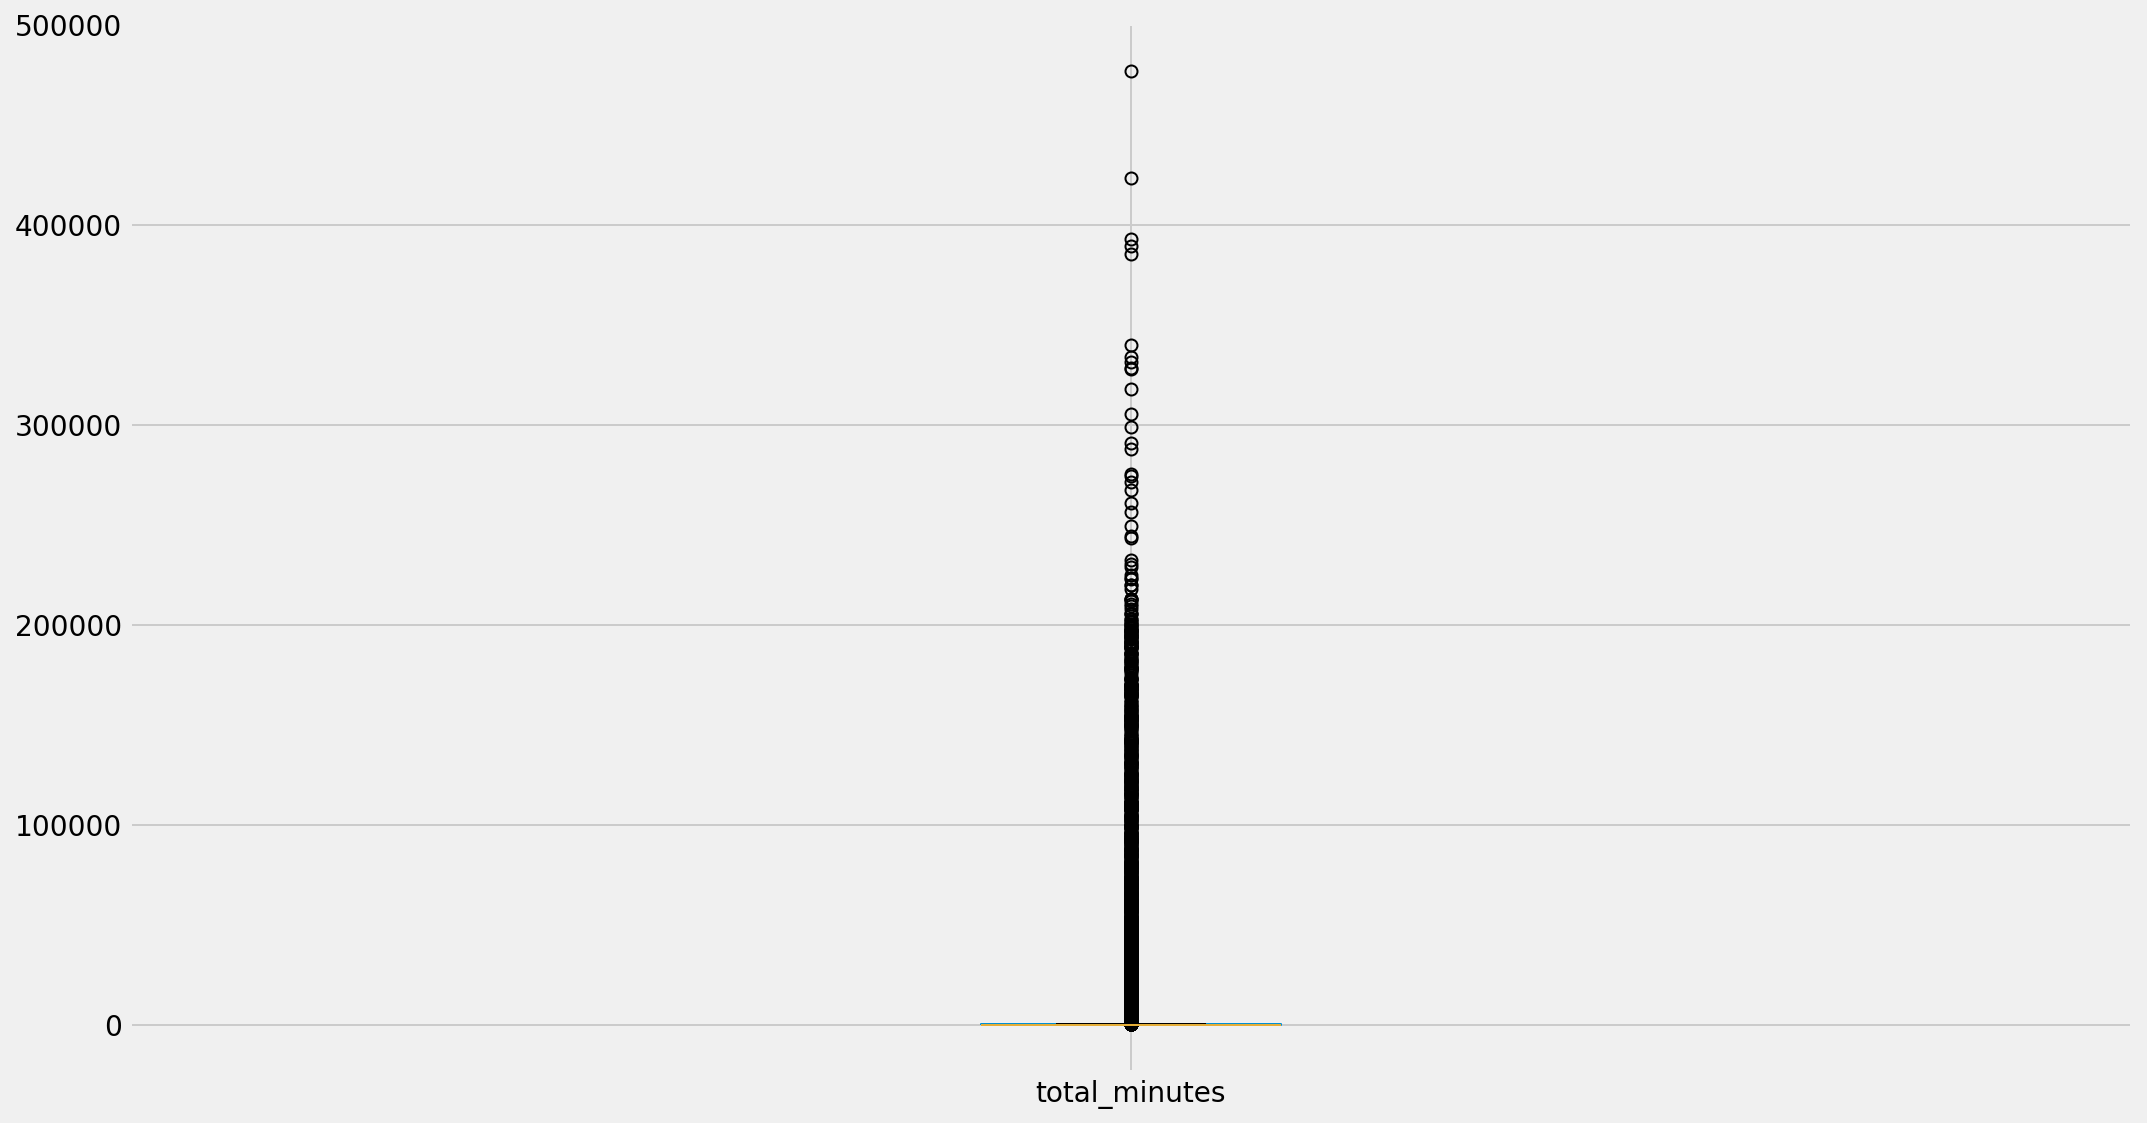

In [10]:
df.total_minutes.describe()
df.total_minutes.plot.box()

In [11]:
df.Course_Completed_Date_SGT.max()

Timestamp('2020-10-01 01:03:00')

# Features for Survival Analysis

In [12]:
df['duration'] = df.total_minutes.copy()
df.loc[df.duration.isnull(), 'duration'] = (datetime.datetime(2020, 10, 1, 0, 0, 0) - df.Course_Enrolled_Date_SGT).map(lambda x: x.total_seconds() // 60)

In [13]:
df['event'] = np.where(df.Completed == 'Completed', 1, 0)

# Surval Analysis

In [14]:
from lifelines.utils import datetimes_to_durations

start_date = df.Course_Enrolled_Date_SGT
end_date = df.Course_Completed_Date_SGT
df['T'], df['E']= datetimes_to_durations(start_date, end_date, fill_date=datetime.datetime.today(), freq='m')

In [15]:
week_in_minutes = 7 * 24 * 60

## Kaplan Meier Estimator

In [16]:
from lifelines import KaplanMeierFitter

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 22890 total observations, 3120 right-censored observations>

<AxesSubplot:xlabel='timeline'>

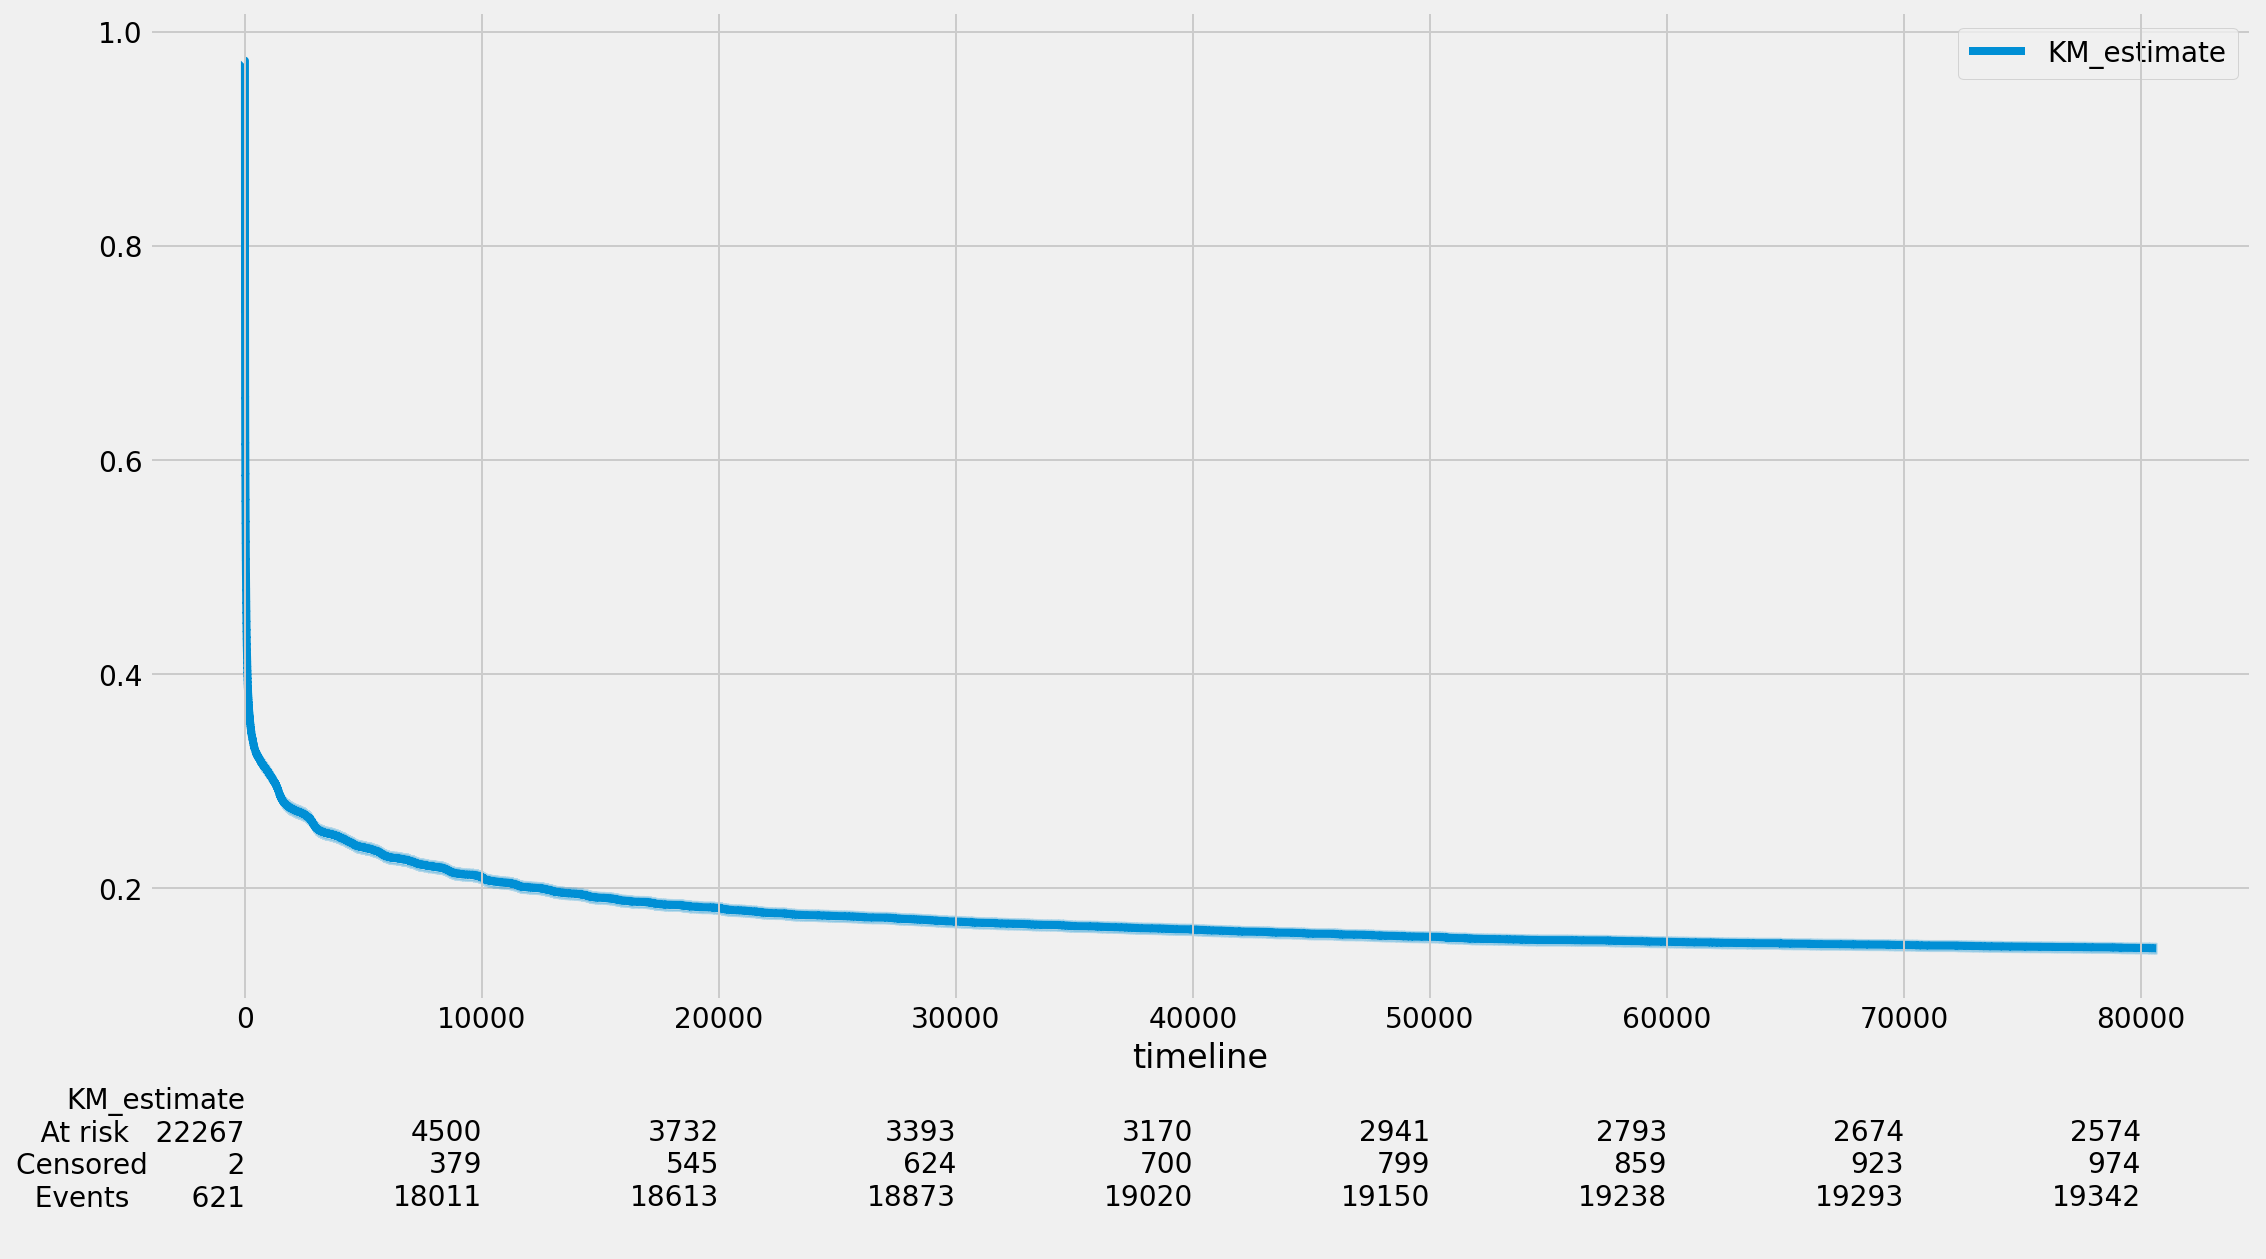

In [17]:
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], df['event'], range(0, week_in_minutes*8,1))
kmf.plot(ci_show=True, at_risk_counts=True)

In [18]:
def fit_kmf(dfg):
    kmf = KaplanMeierFitter(label=dfg.name)
    kmf.fit(dfg['duration'], dfg['event'], range(0, week_in_minutes * 4,1))
    kmf.plot(ci_show=True)

""


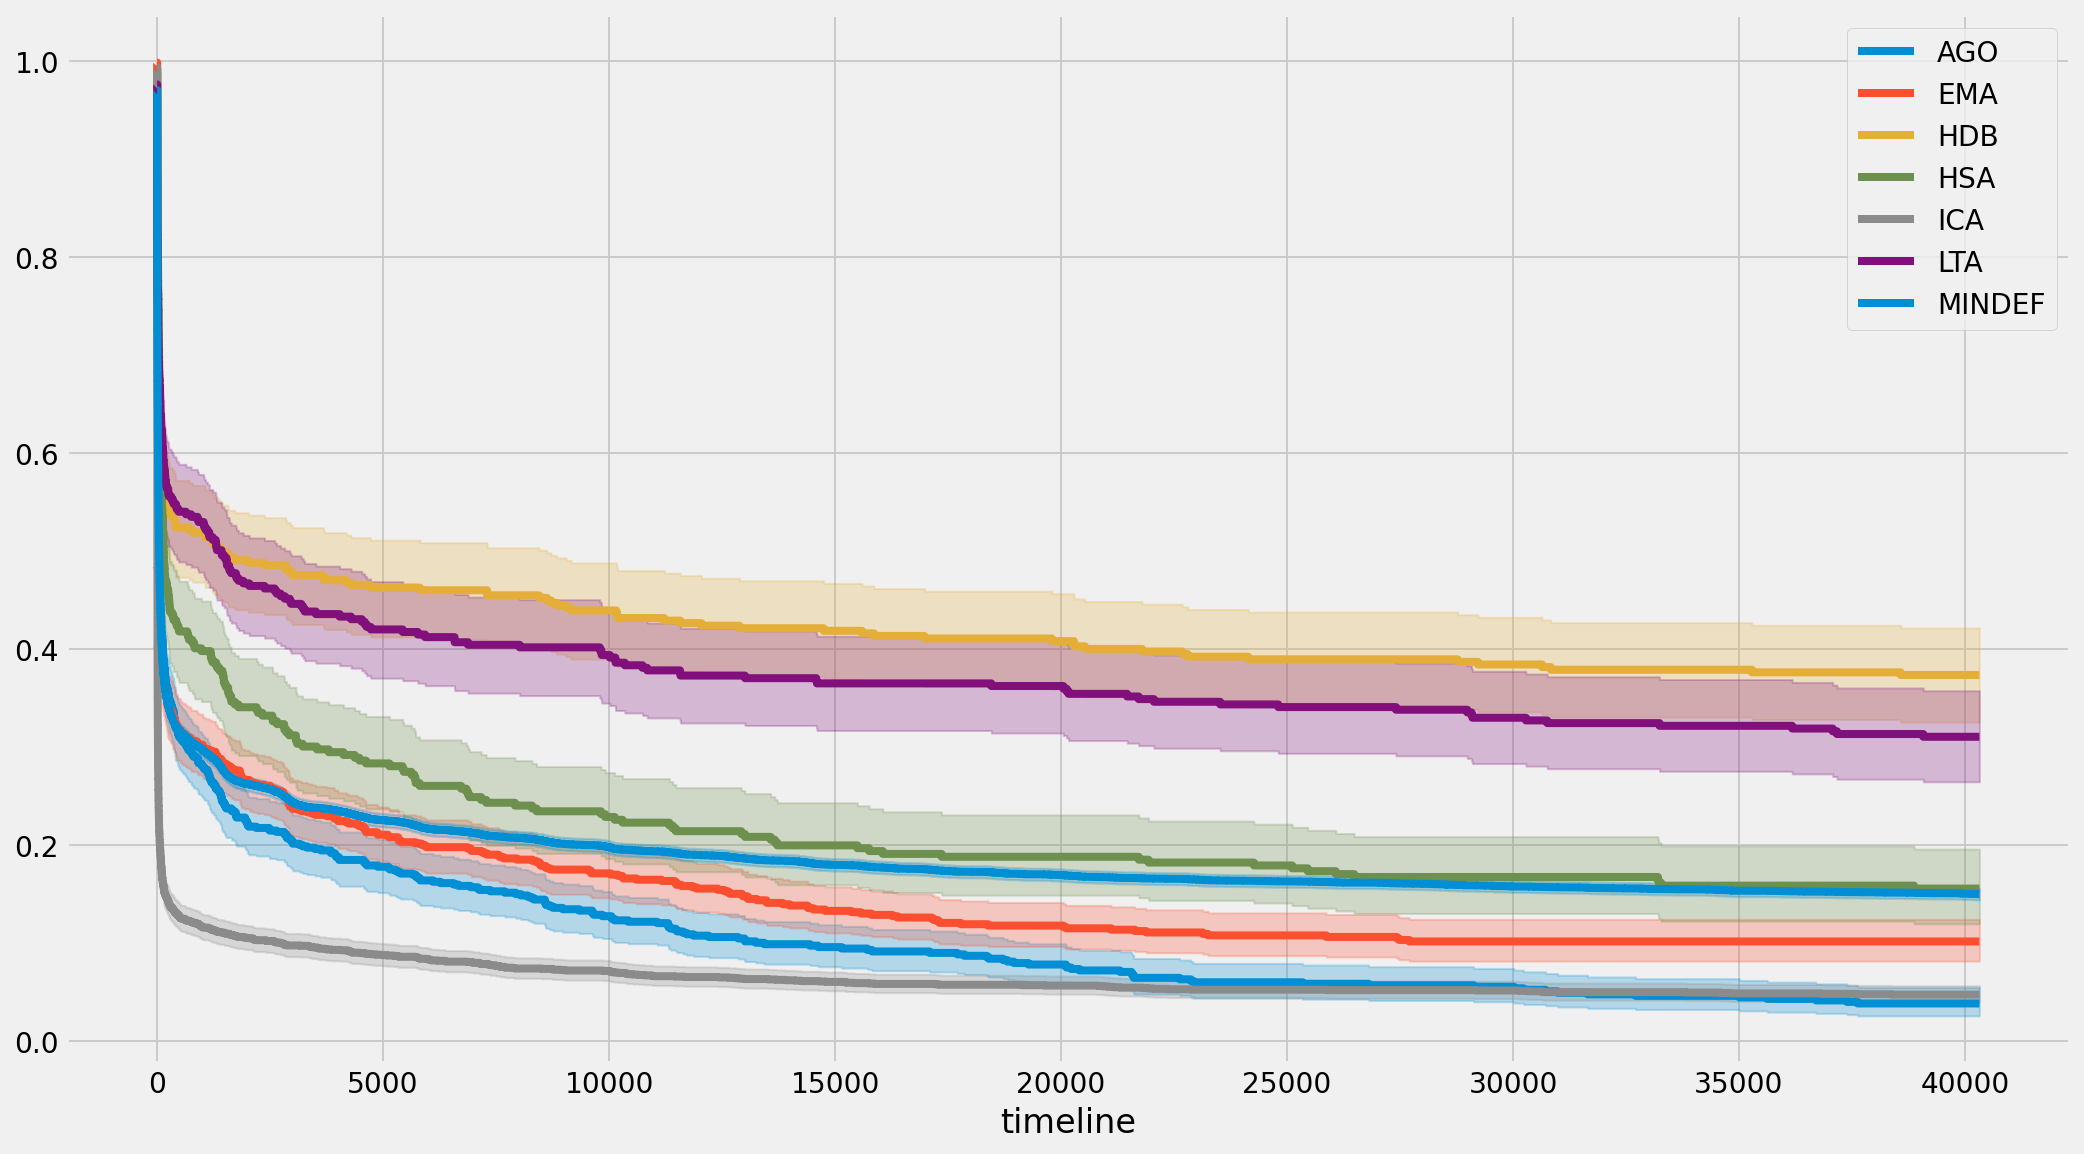

In [19]:
df[df.Agency.isin(df.ds.cumsum('Agency').head(7).Agency)].groupby('Agency').apply(fit_kmf)

# Experimental

In [20]:
df.ds.xb()

Converted Course_Completed_Date_SGT
Converted Course_Enrolled_Date_SGT


Error: could not locate runnable browser

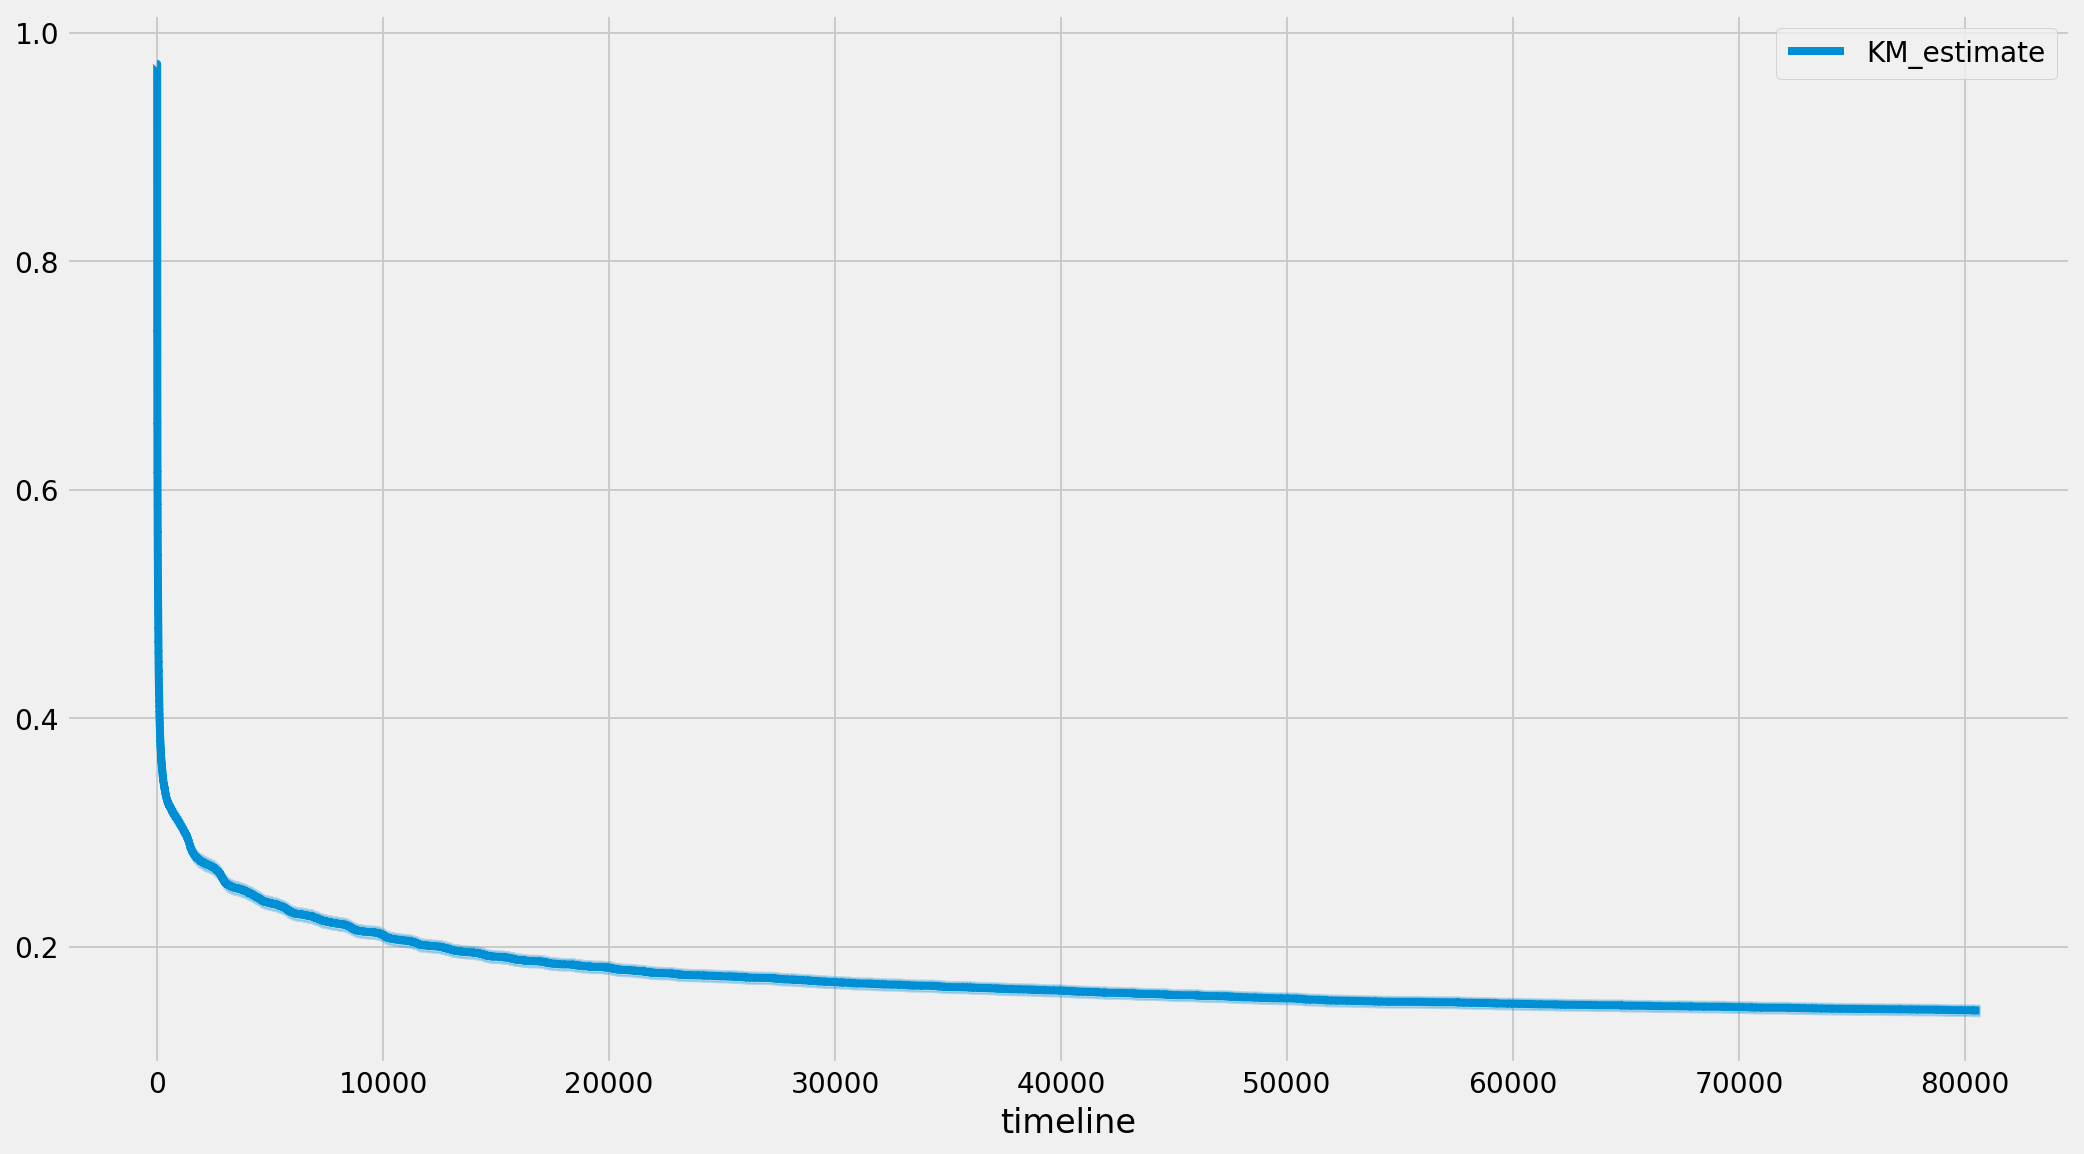

In [19]:
kmf.plot()

In [30]:
len(df) * 0.05

1144.5

In [74]:
completion_rate_btw = kmf.predict(week_in_minutes * 3) - kmf.predict(week_in_minutes * 520)
completion_rate_btw

0.024603004879639706

In [103]:
kmf.predict(week_in_minutes * 3)

0.16878891724658443

In [75]:
# Completion Rate for Those Not Complete within 1st Week
(len(df) * completion_rate_btw) / (len(df) * kmf.predict(week_in_minutes))

0.11752006486079826

In [ ]:
def generate_probablity_of_completion(x)
    kmf.fit(df['duration'], df['event'], range(0, week_in_minutes*8,1))
    completion_rate_btw = kmf.predict(week_in_minutes * x) - kmf.predict(week_in_minutes * 520)
    return (len(df) * completion_rate_btw) / (len(df) * kmf.predict(week_in_minutes * x))

In [109]:
def generate_probablity_of_completion(dfx, x):
    kmf.fit(dfx['duration'], dfx['event'], range(0, week_in_minutes*52,1))
    completion_rate_btw = kmf.predict(week_in_minutes * x) - kmf.predict(week_in_minutes * 520)
    return (len(df) * completion_rate_btw) / (len(df) * kmf.predict(week_in_minutes * x))

Text(0.5, 1.0, 'PSD | n=110')

Text(0.5, 1.0, 'MINDEF | n=14560')

Text(0.5, 1.0, 'NEA | n=264')

Text(0.5, 1.0, 'AGO | n=766')

Text(0.5, 1.0, 'MSF | n=261')

Text(0.5, 1.0, 'IRAS | n=297')

Text(0.5, 1.0, 'PA | n=86')

Text(0.5, 1.0, 'SPF | n=261')

Text(0.5, 1.0, 'NAC | n=77')

Text(0.5, 1.0, 'SCB | n=90')

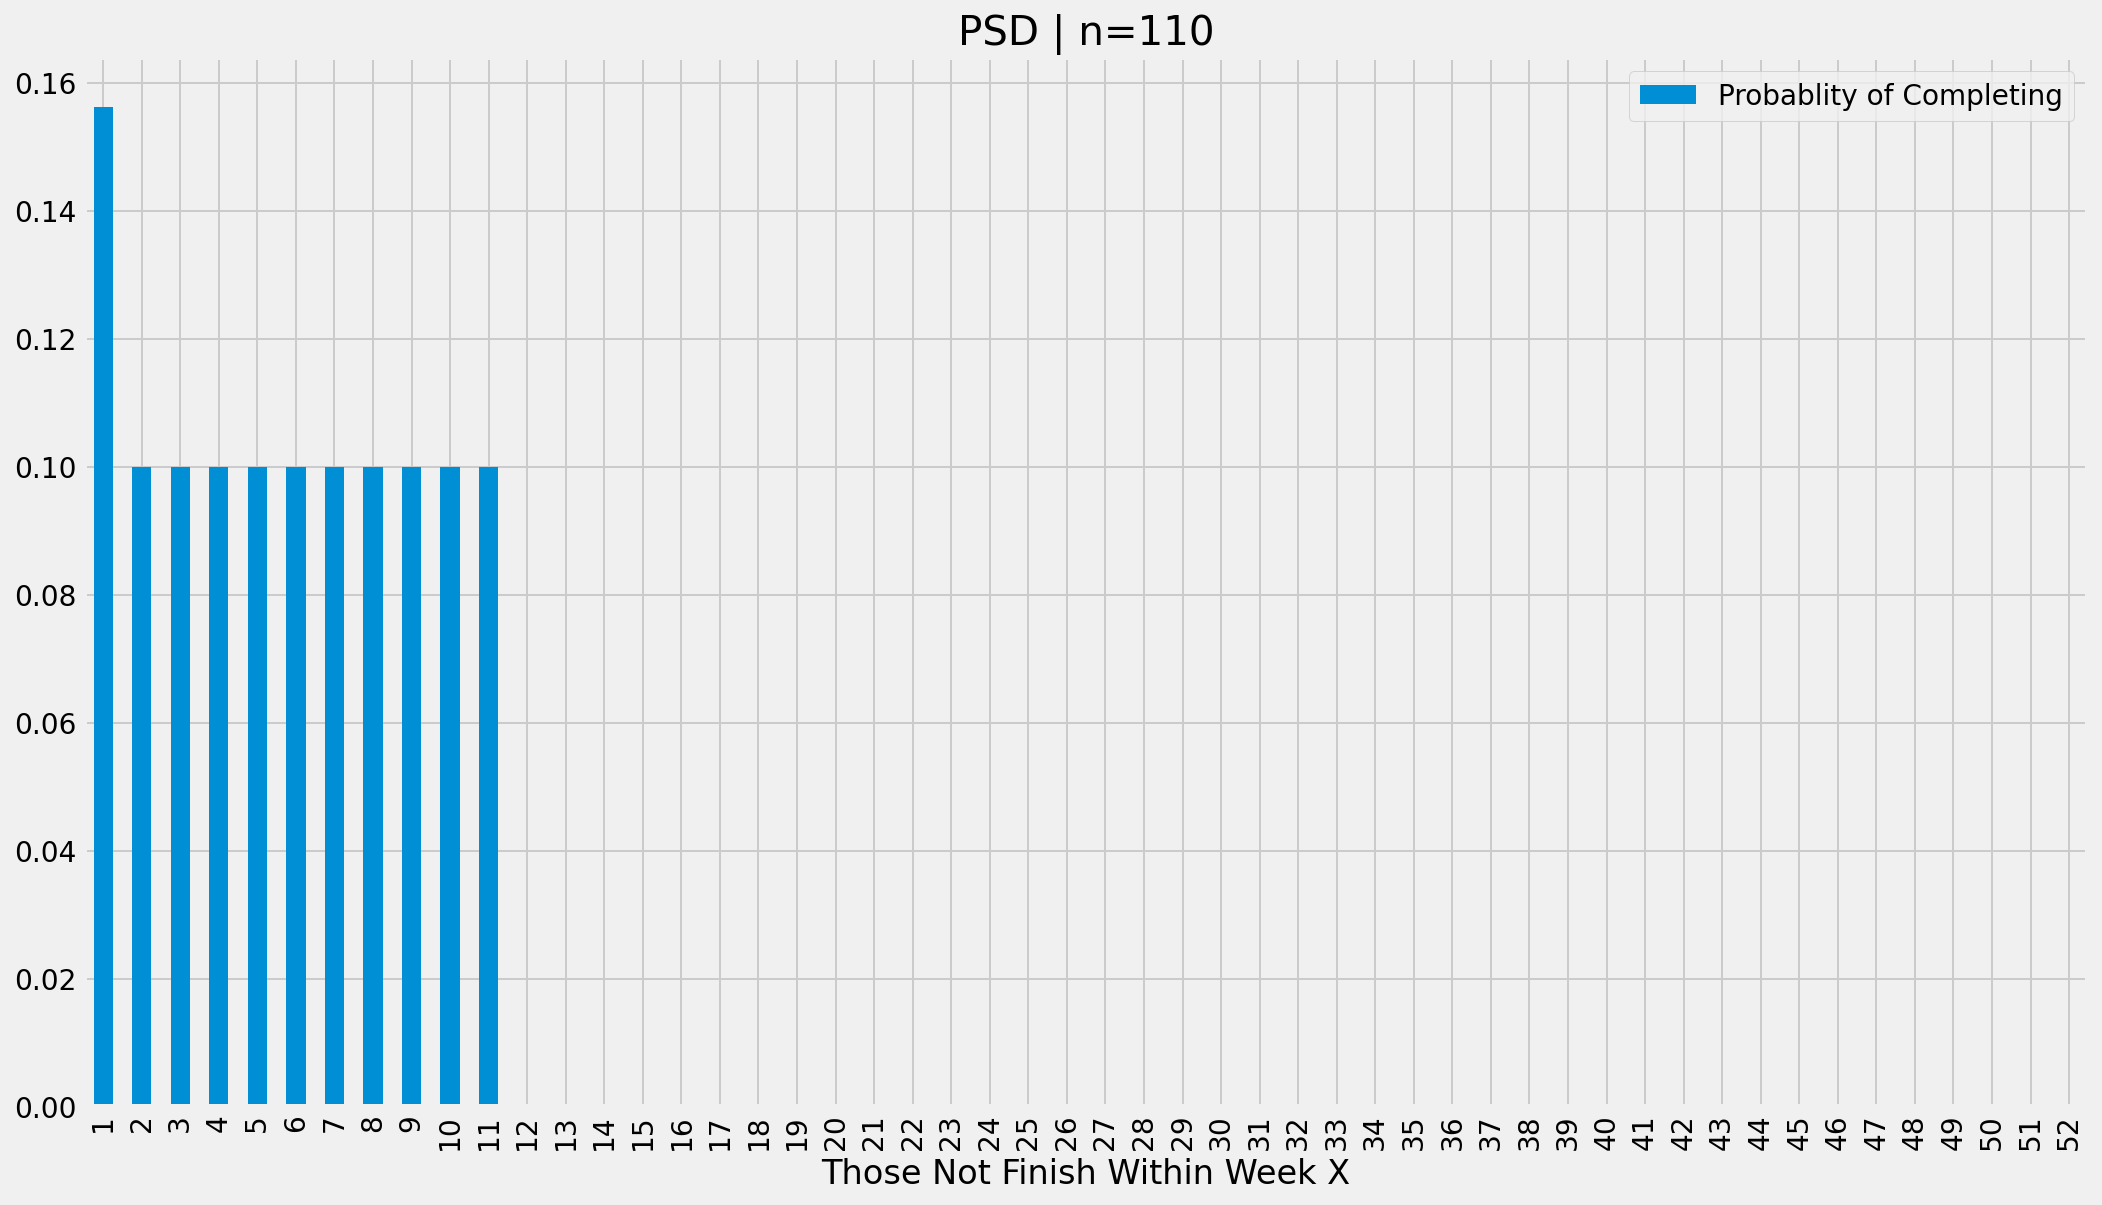

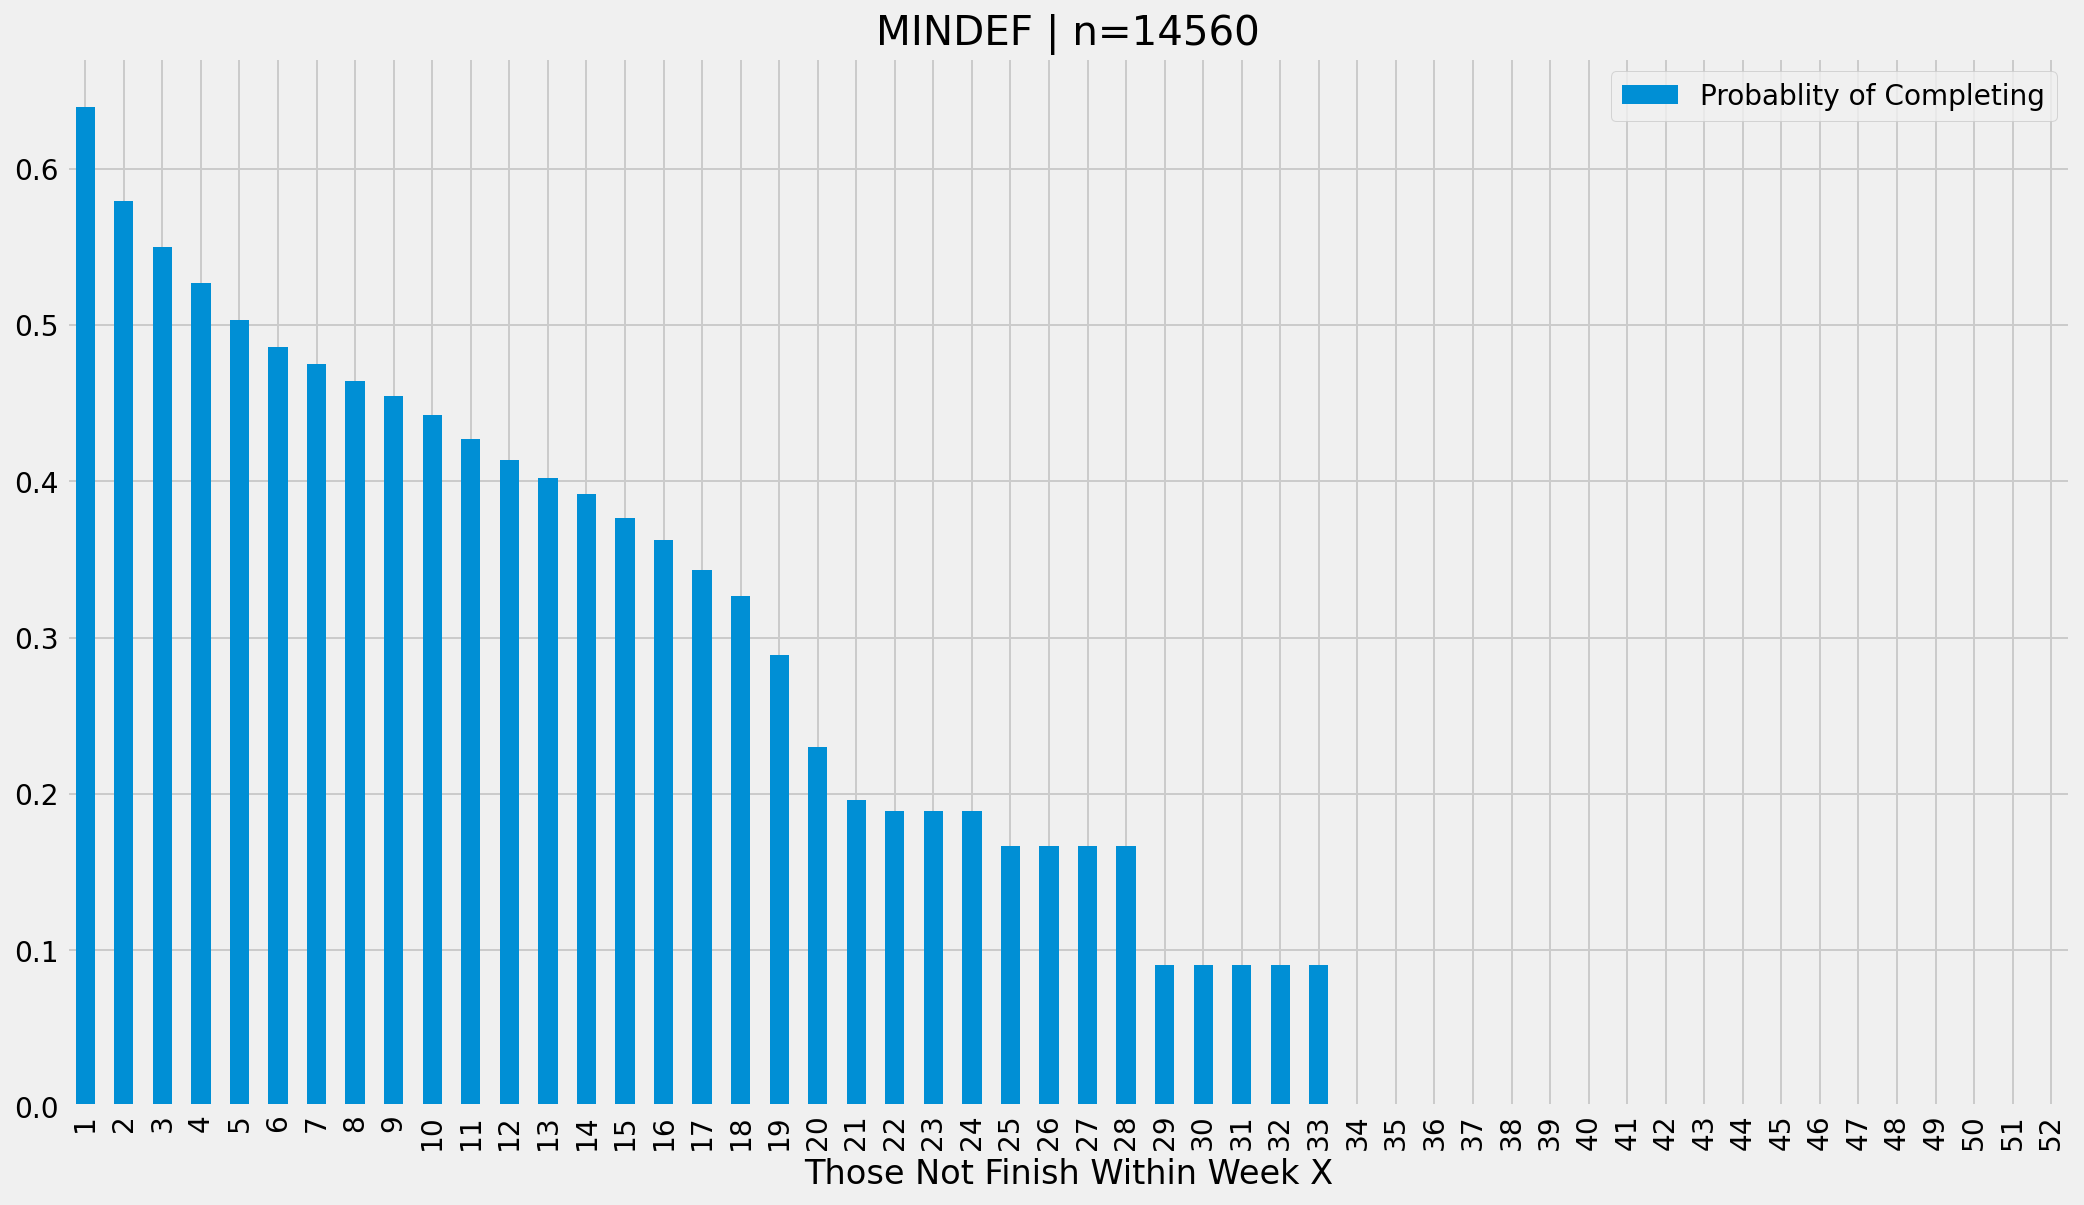

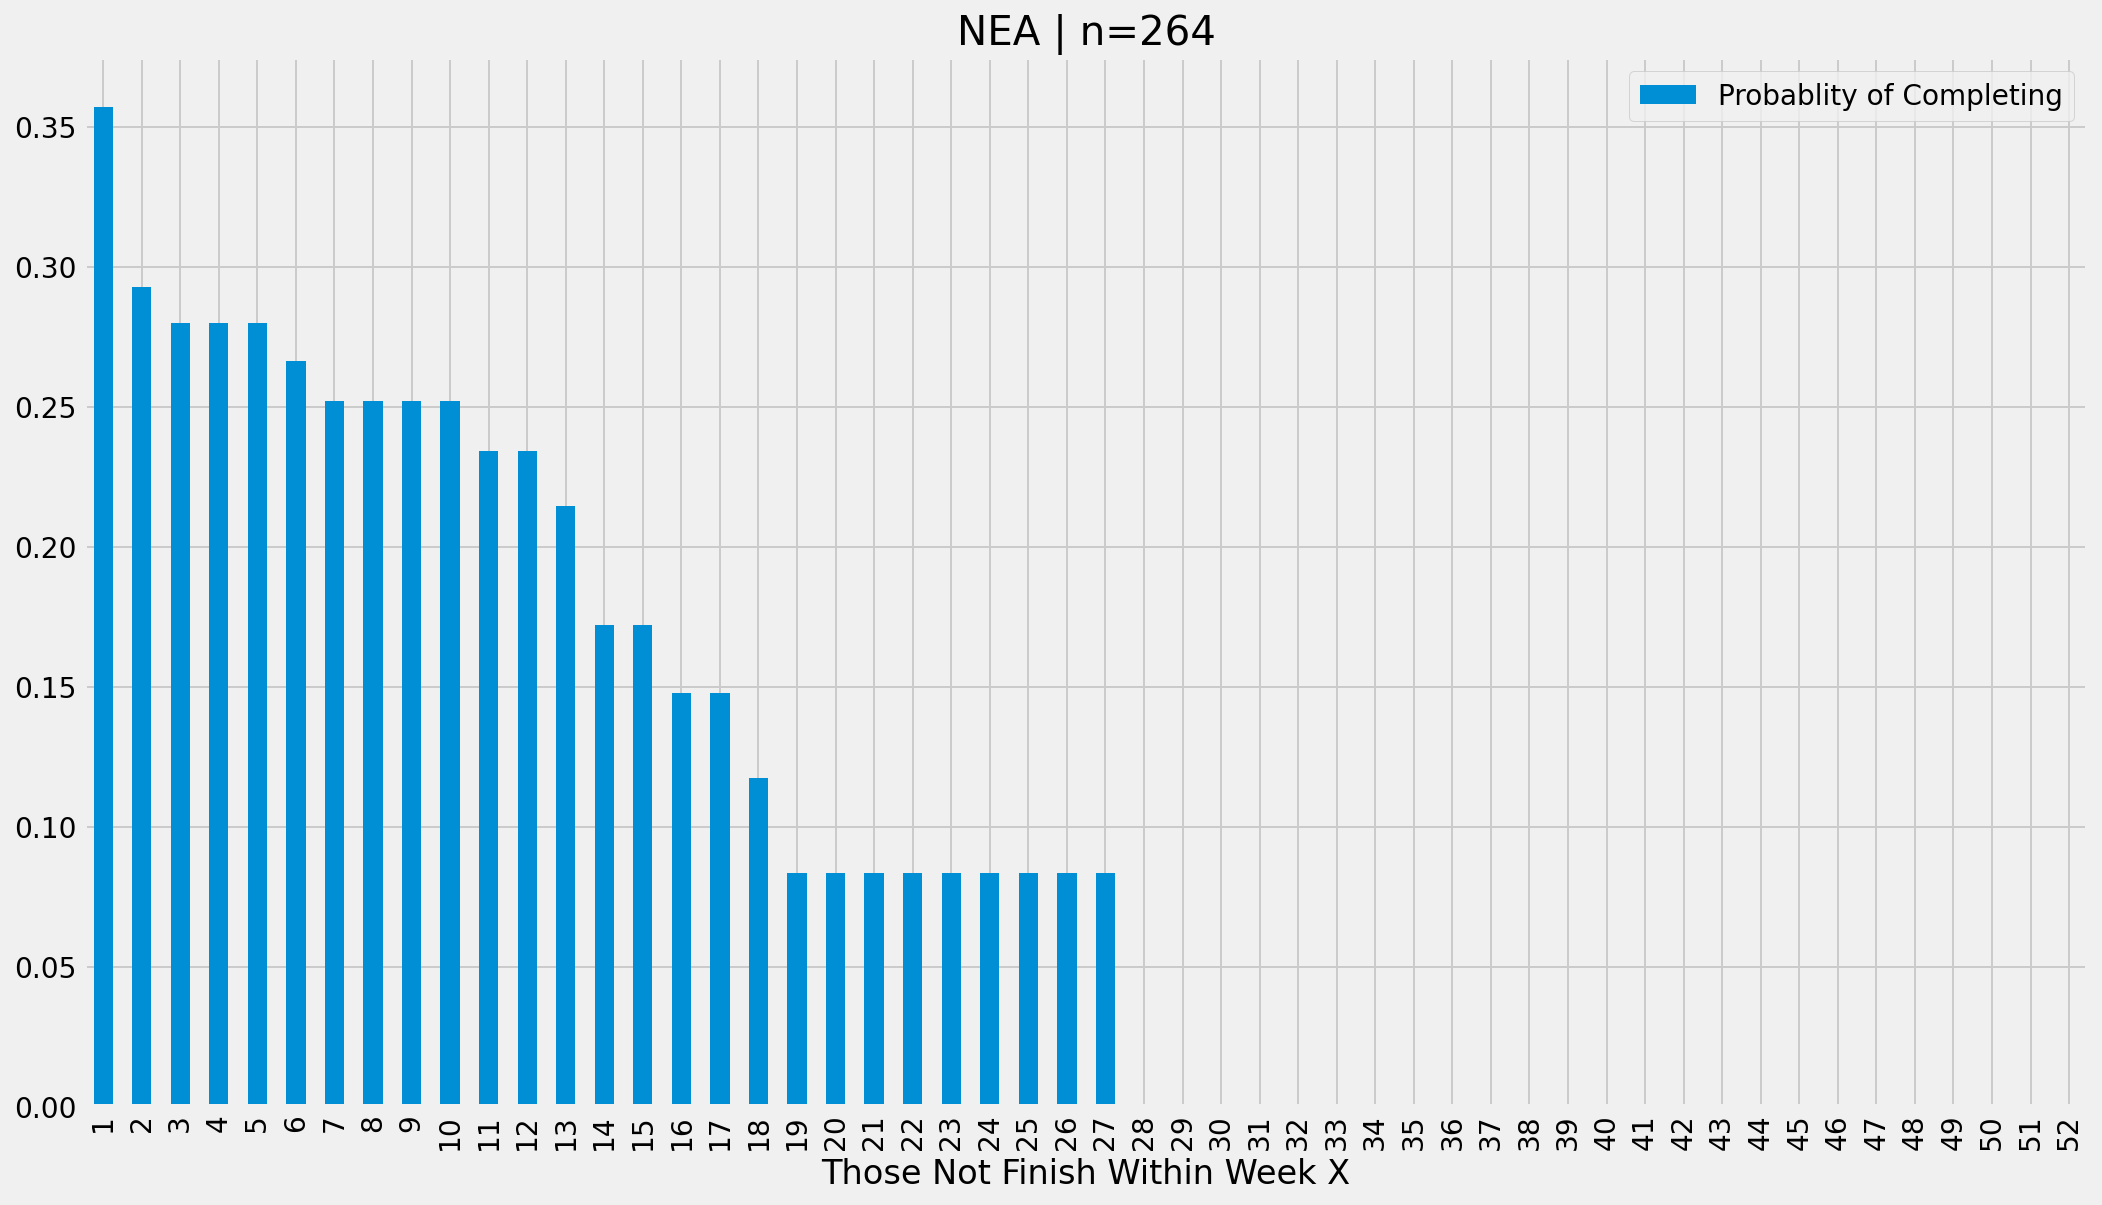

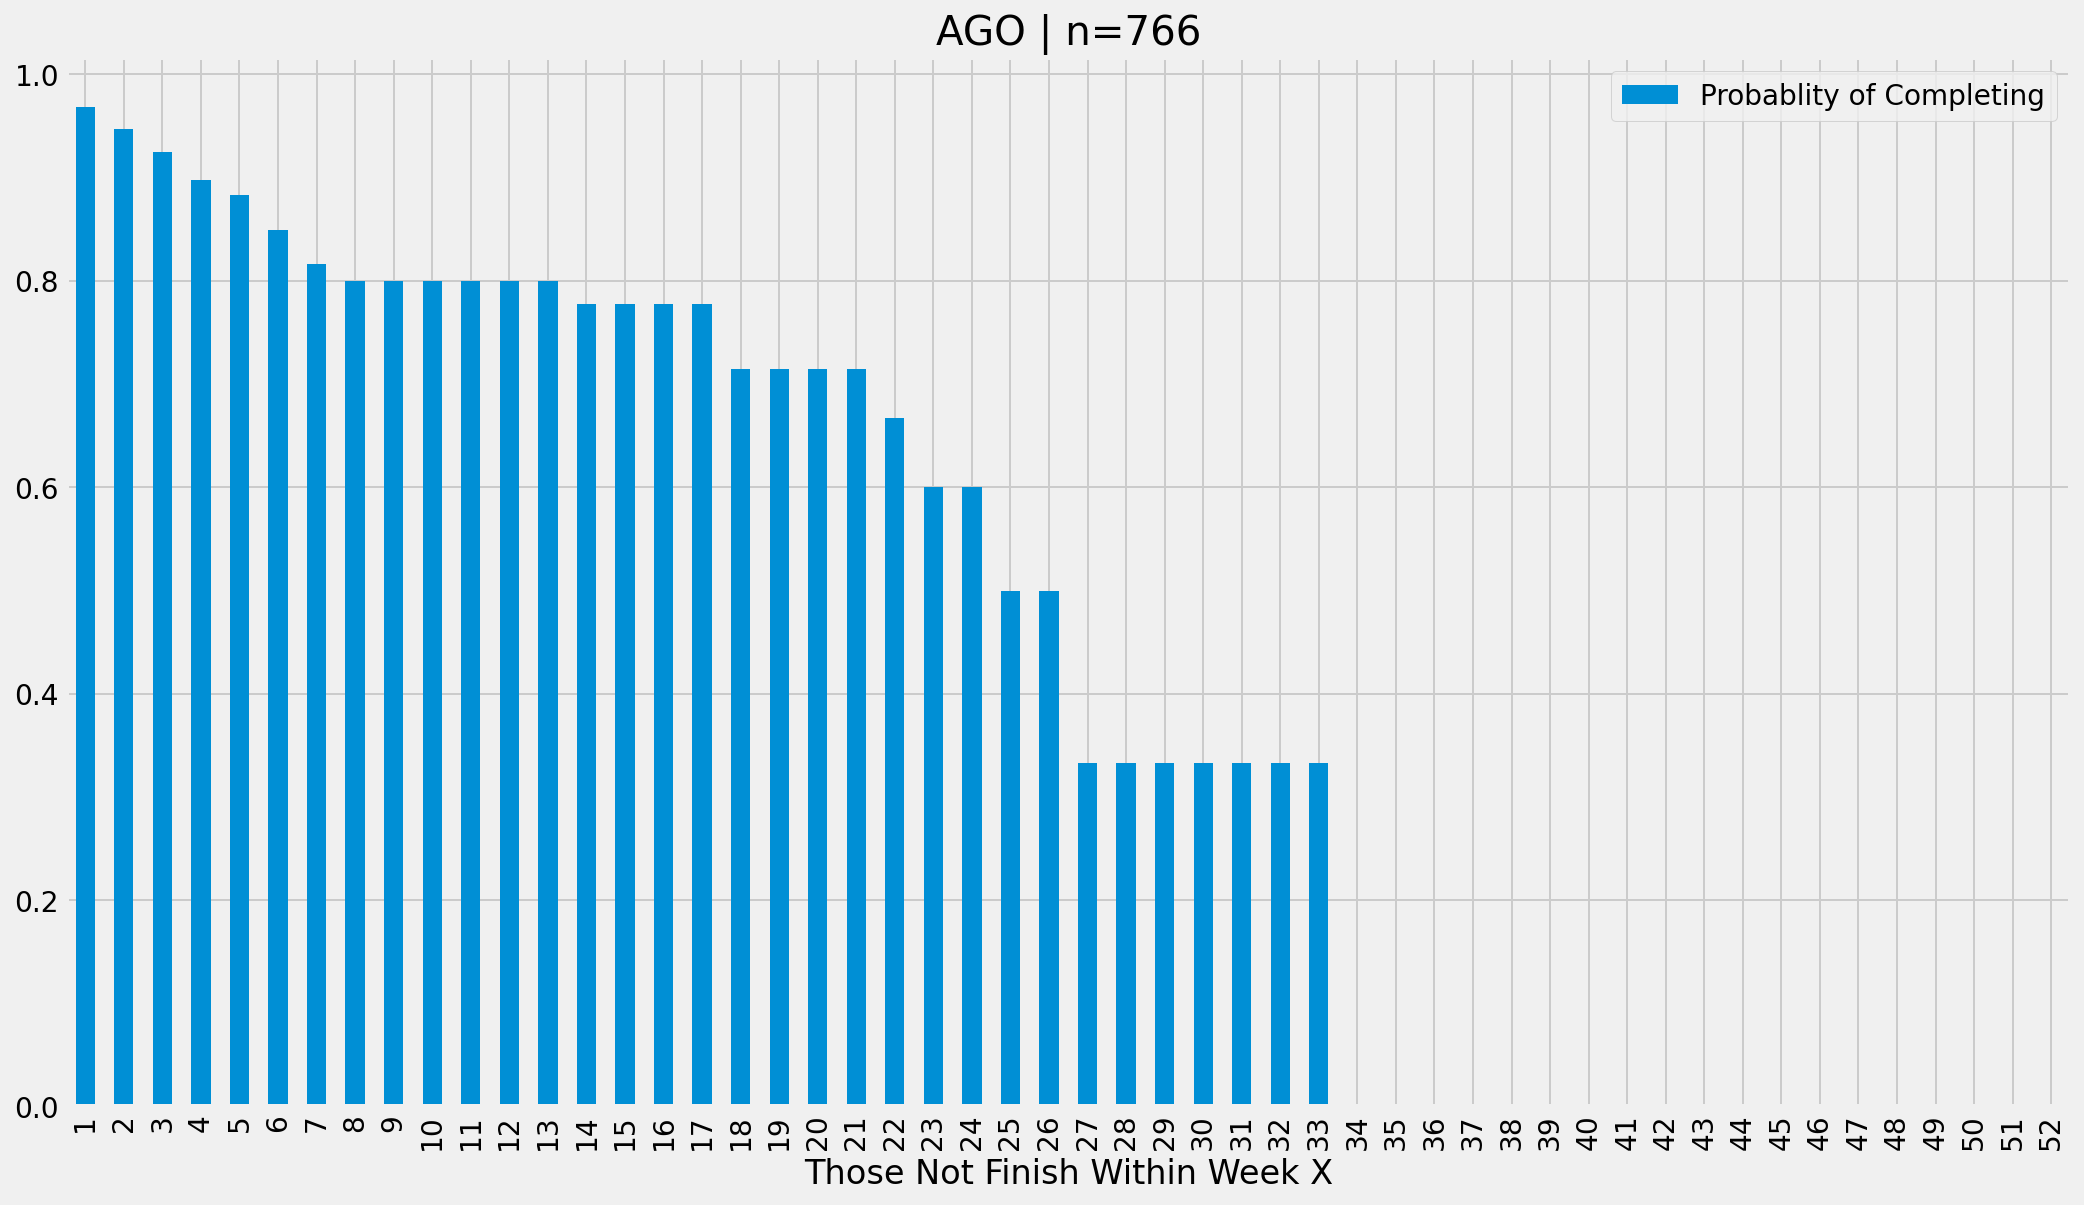

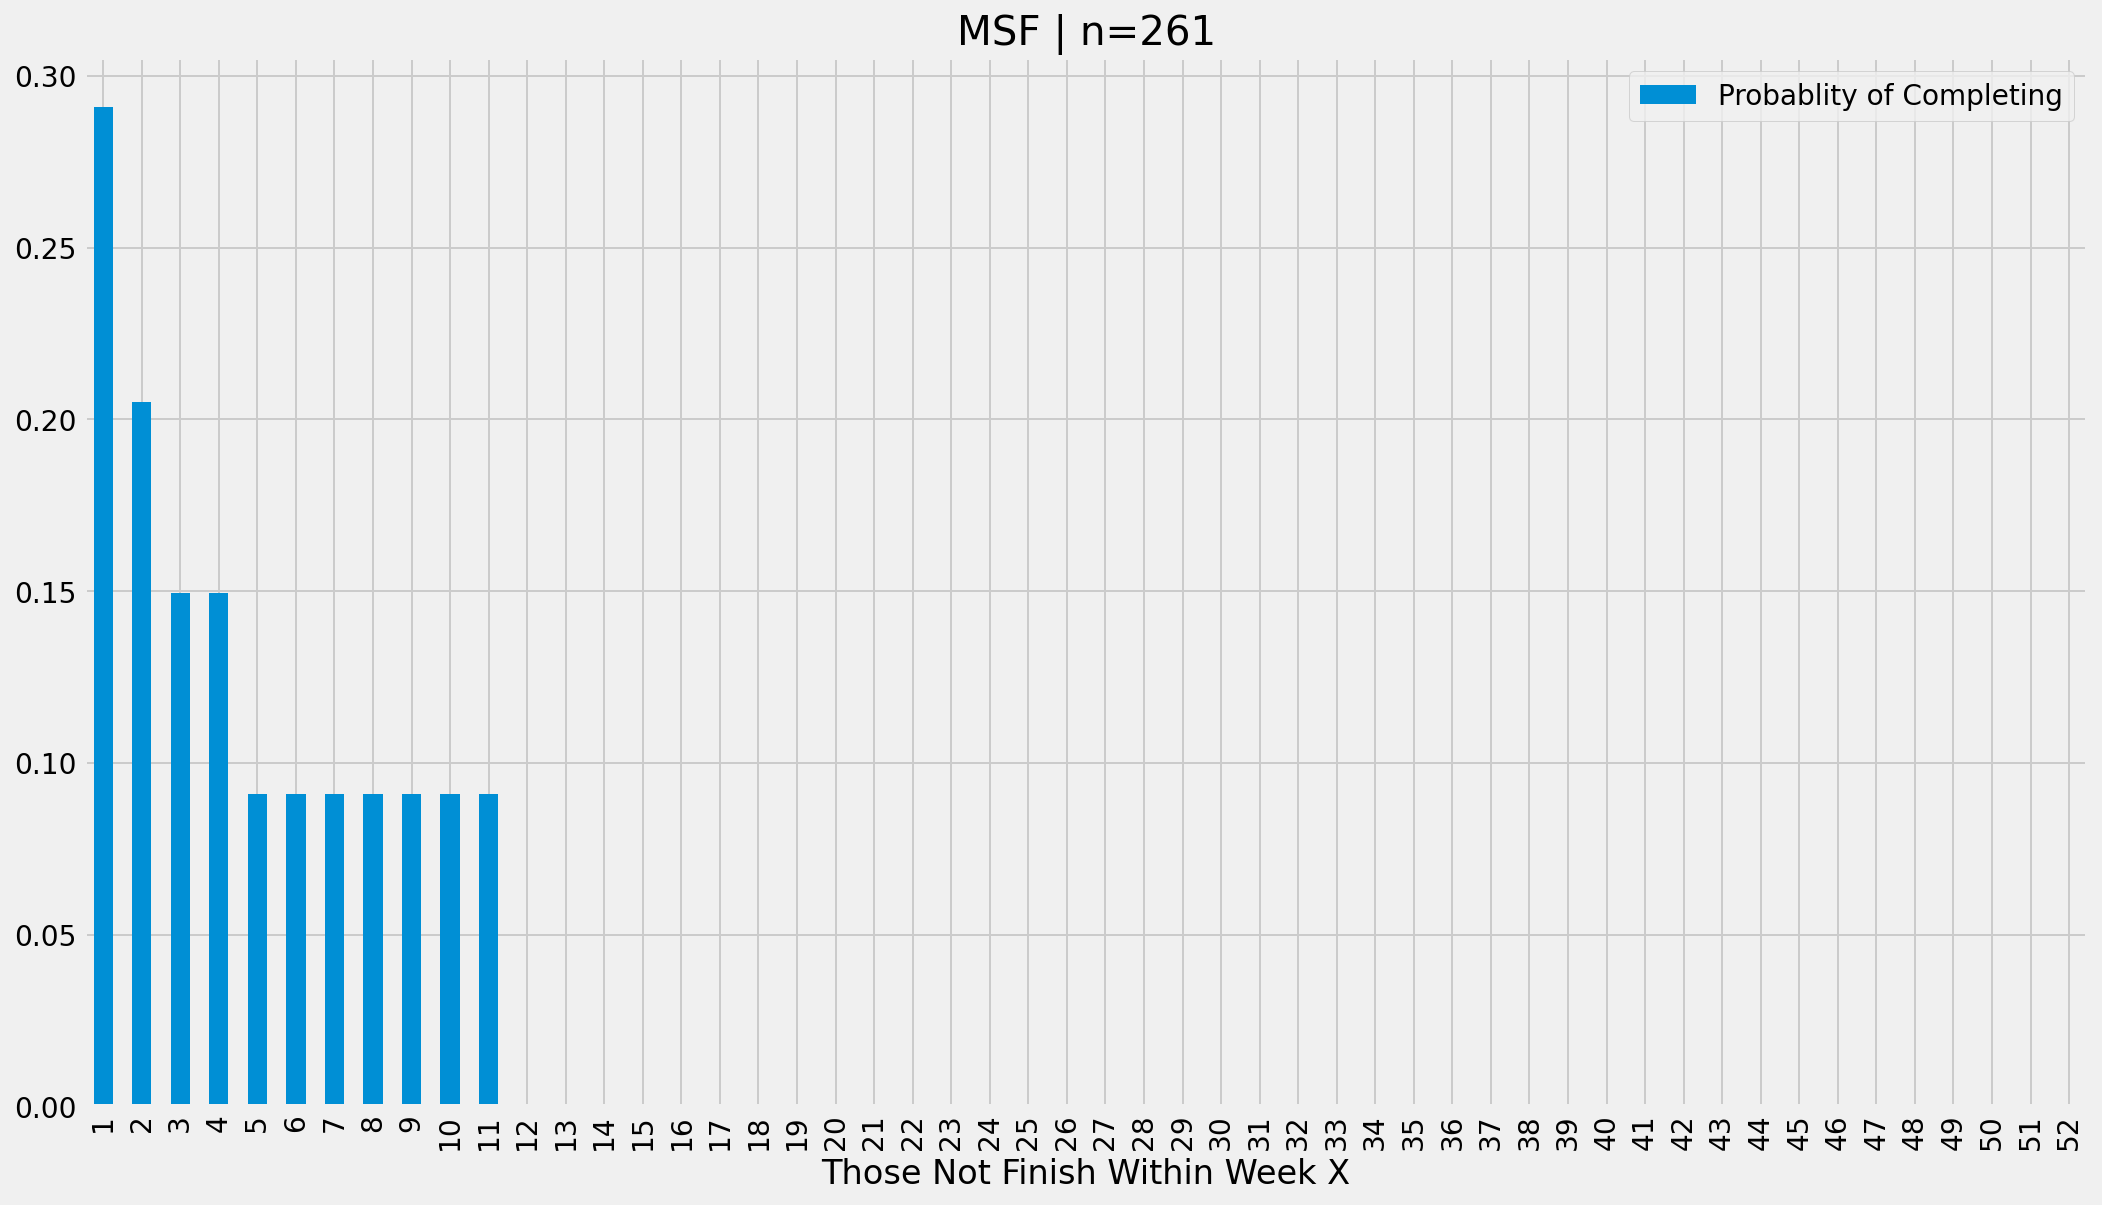

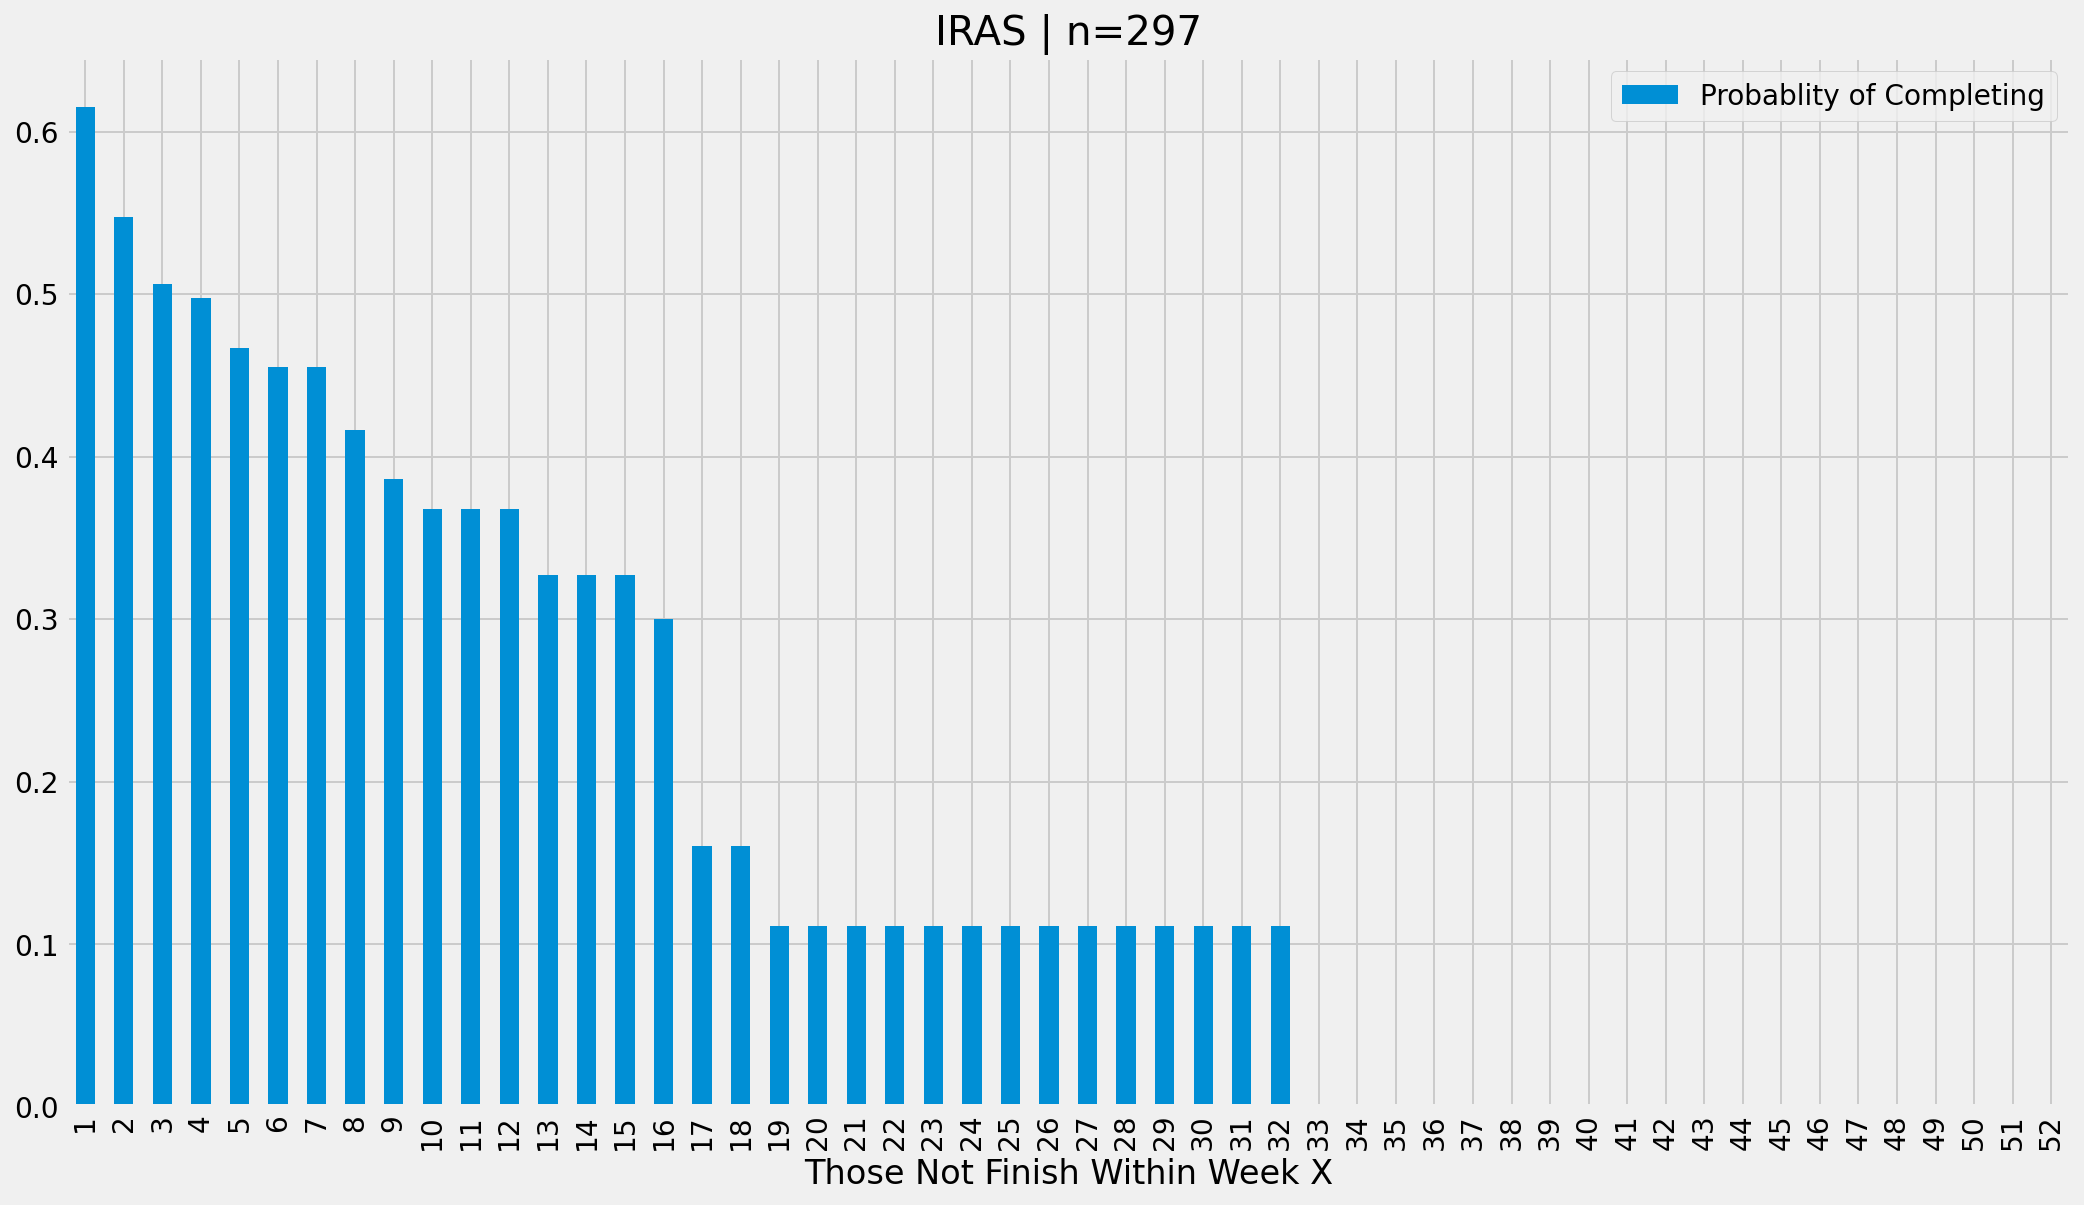

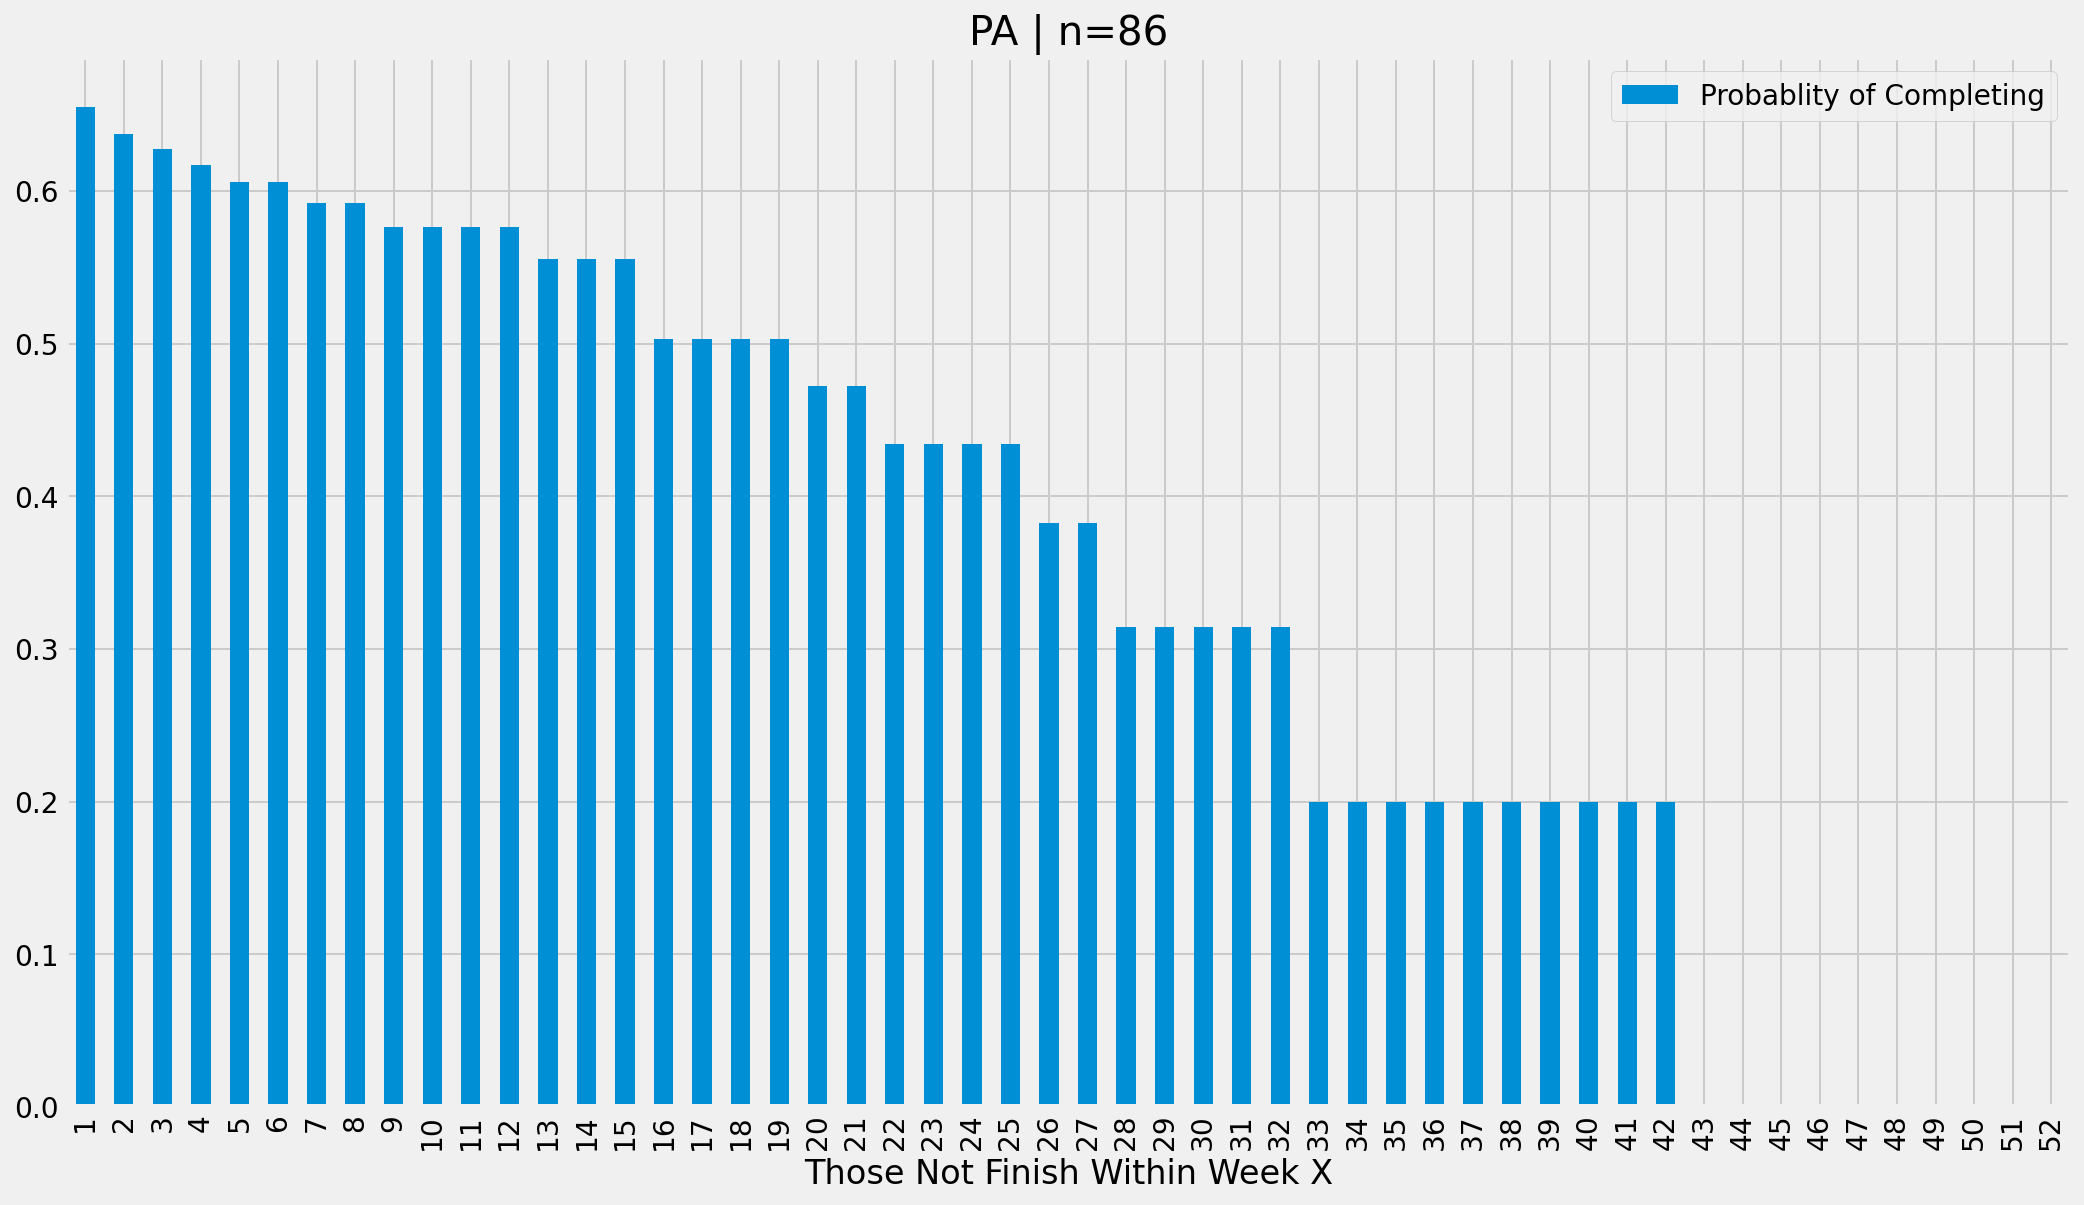

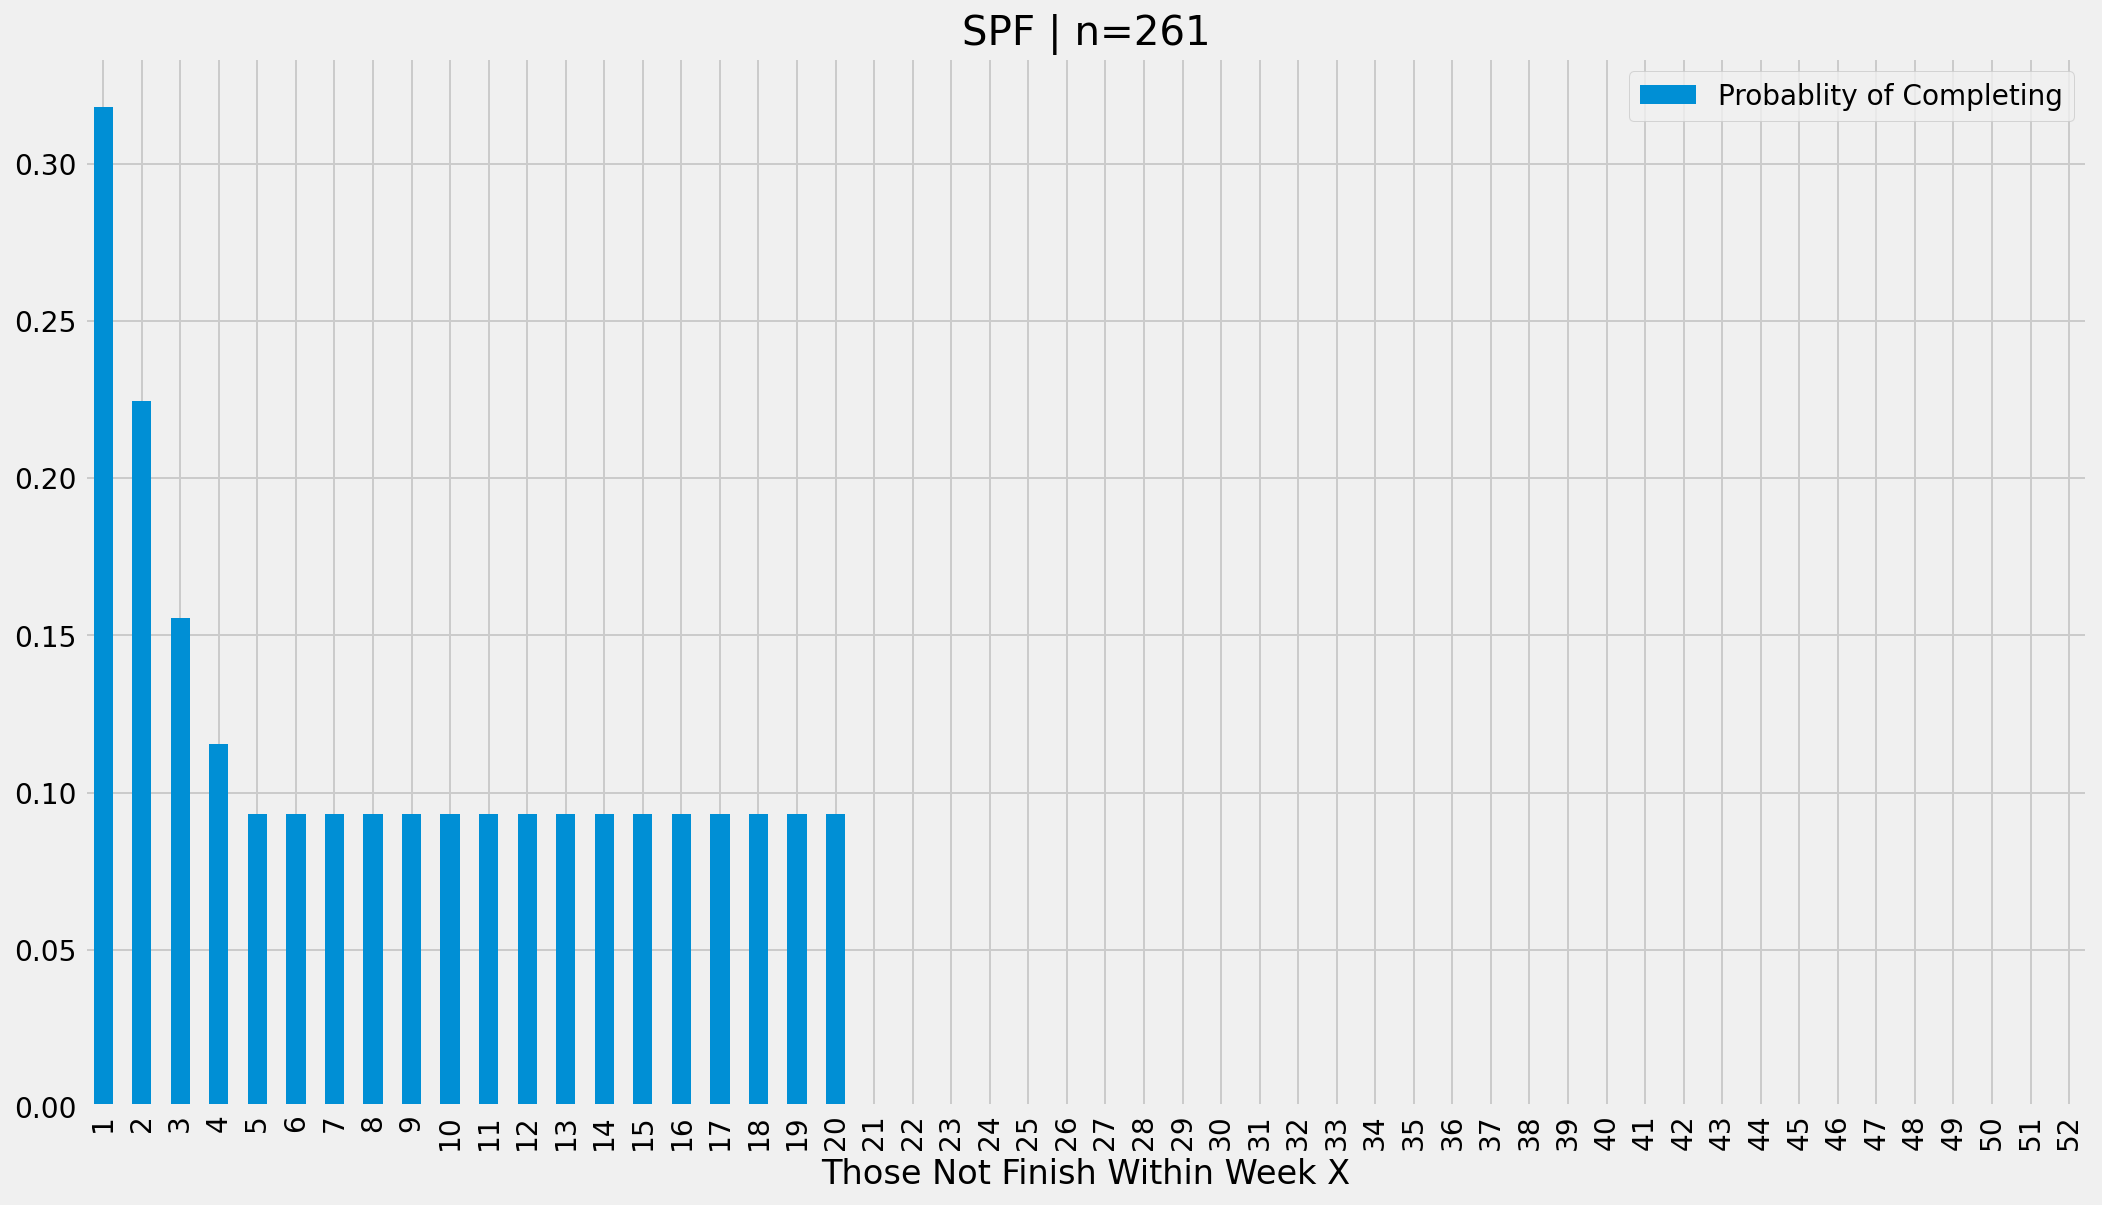

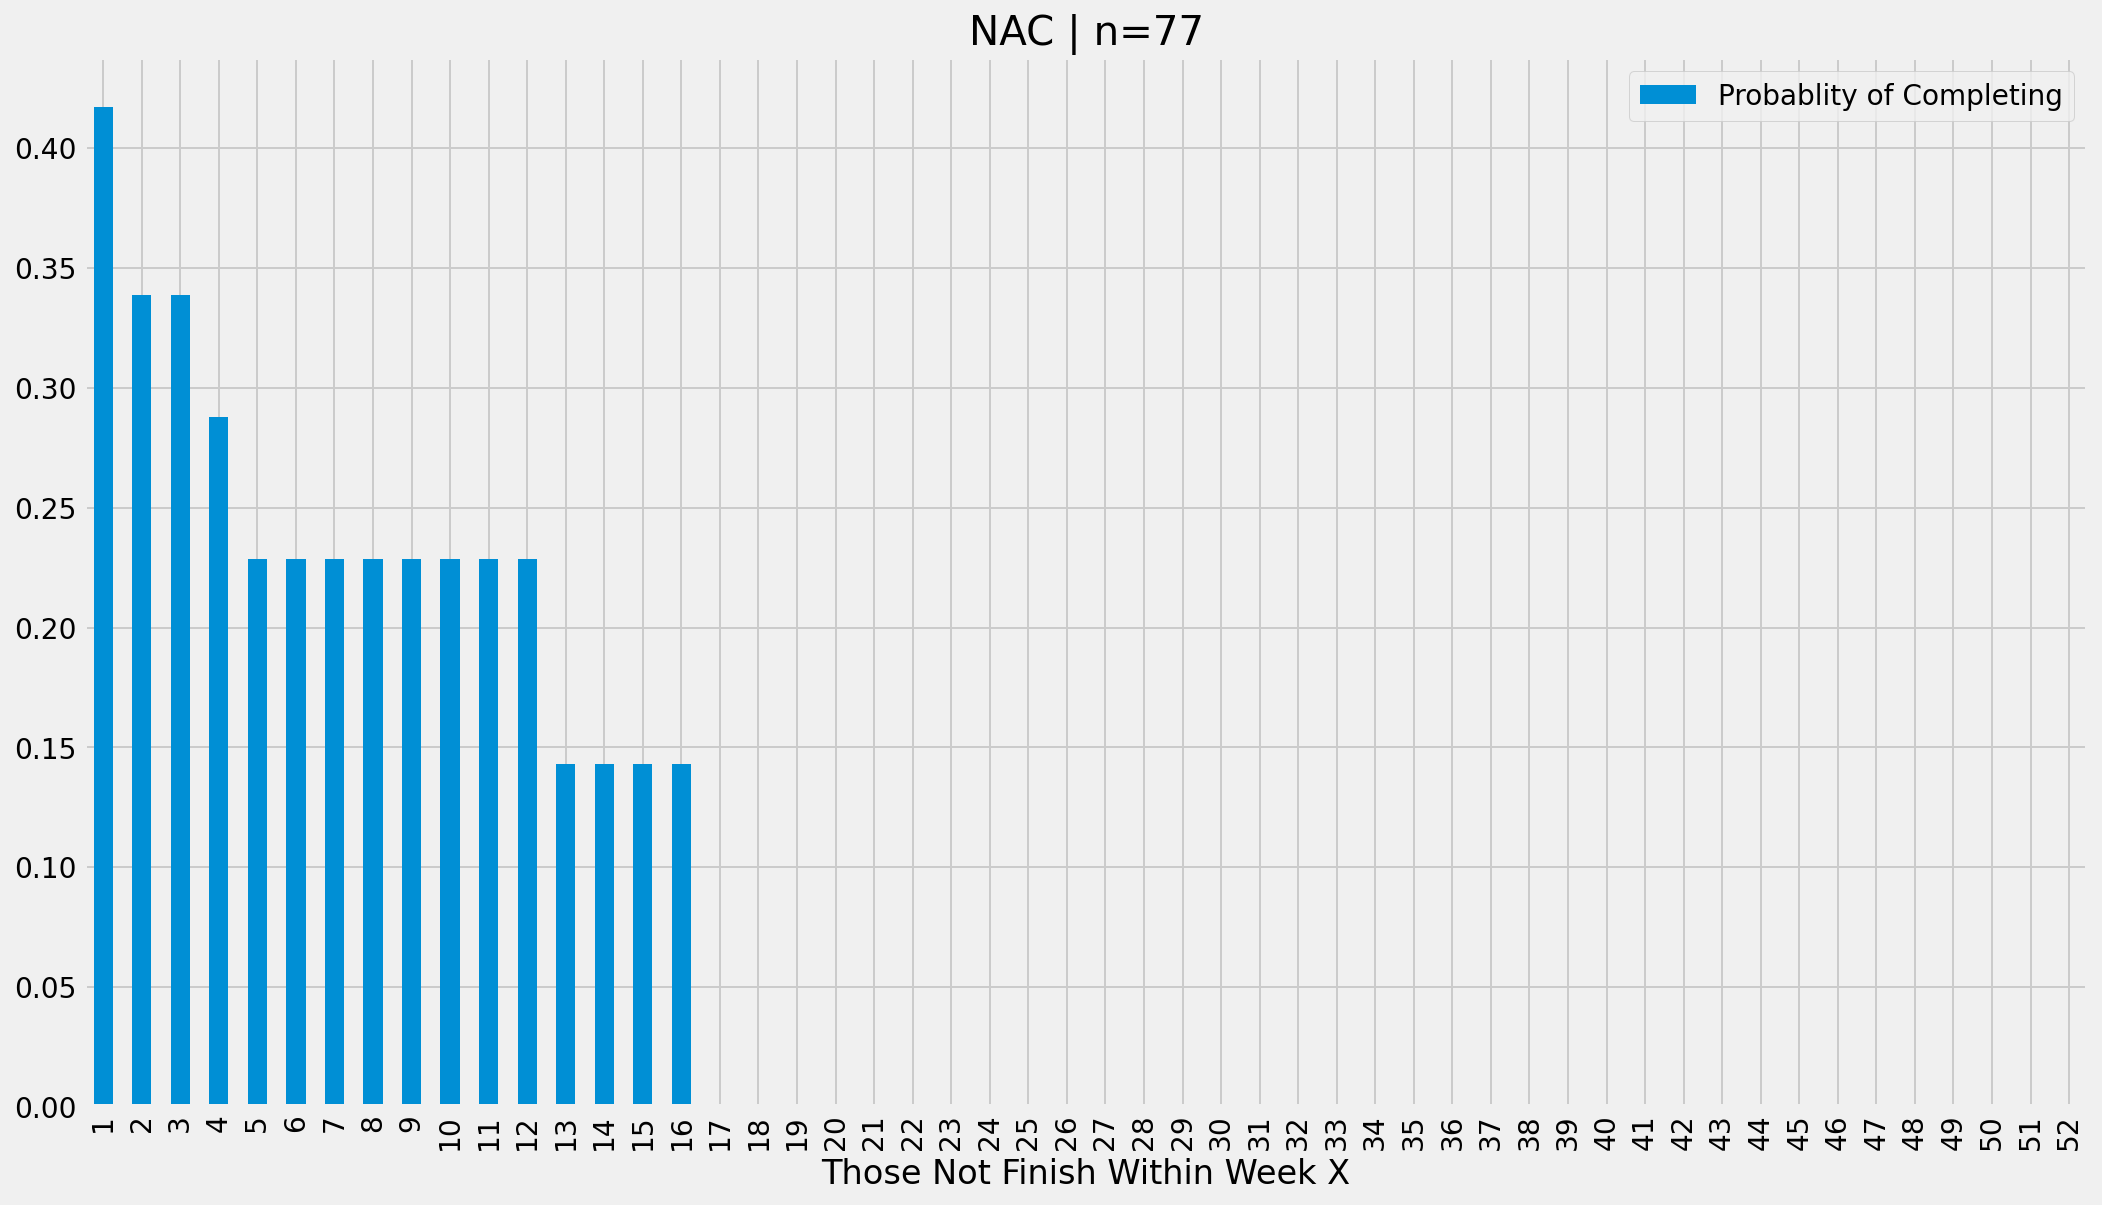

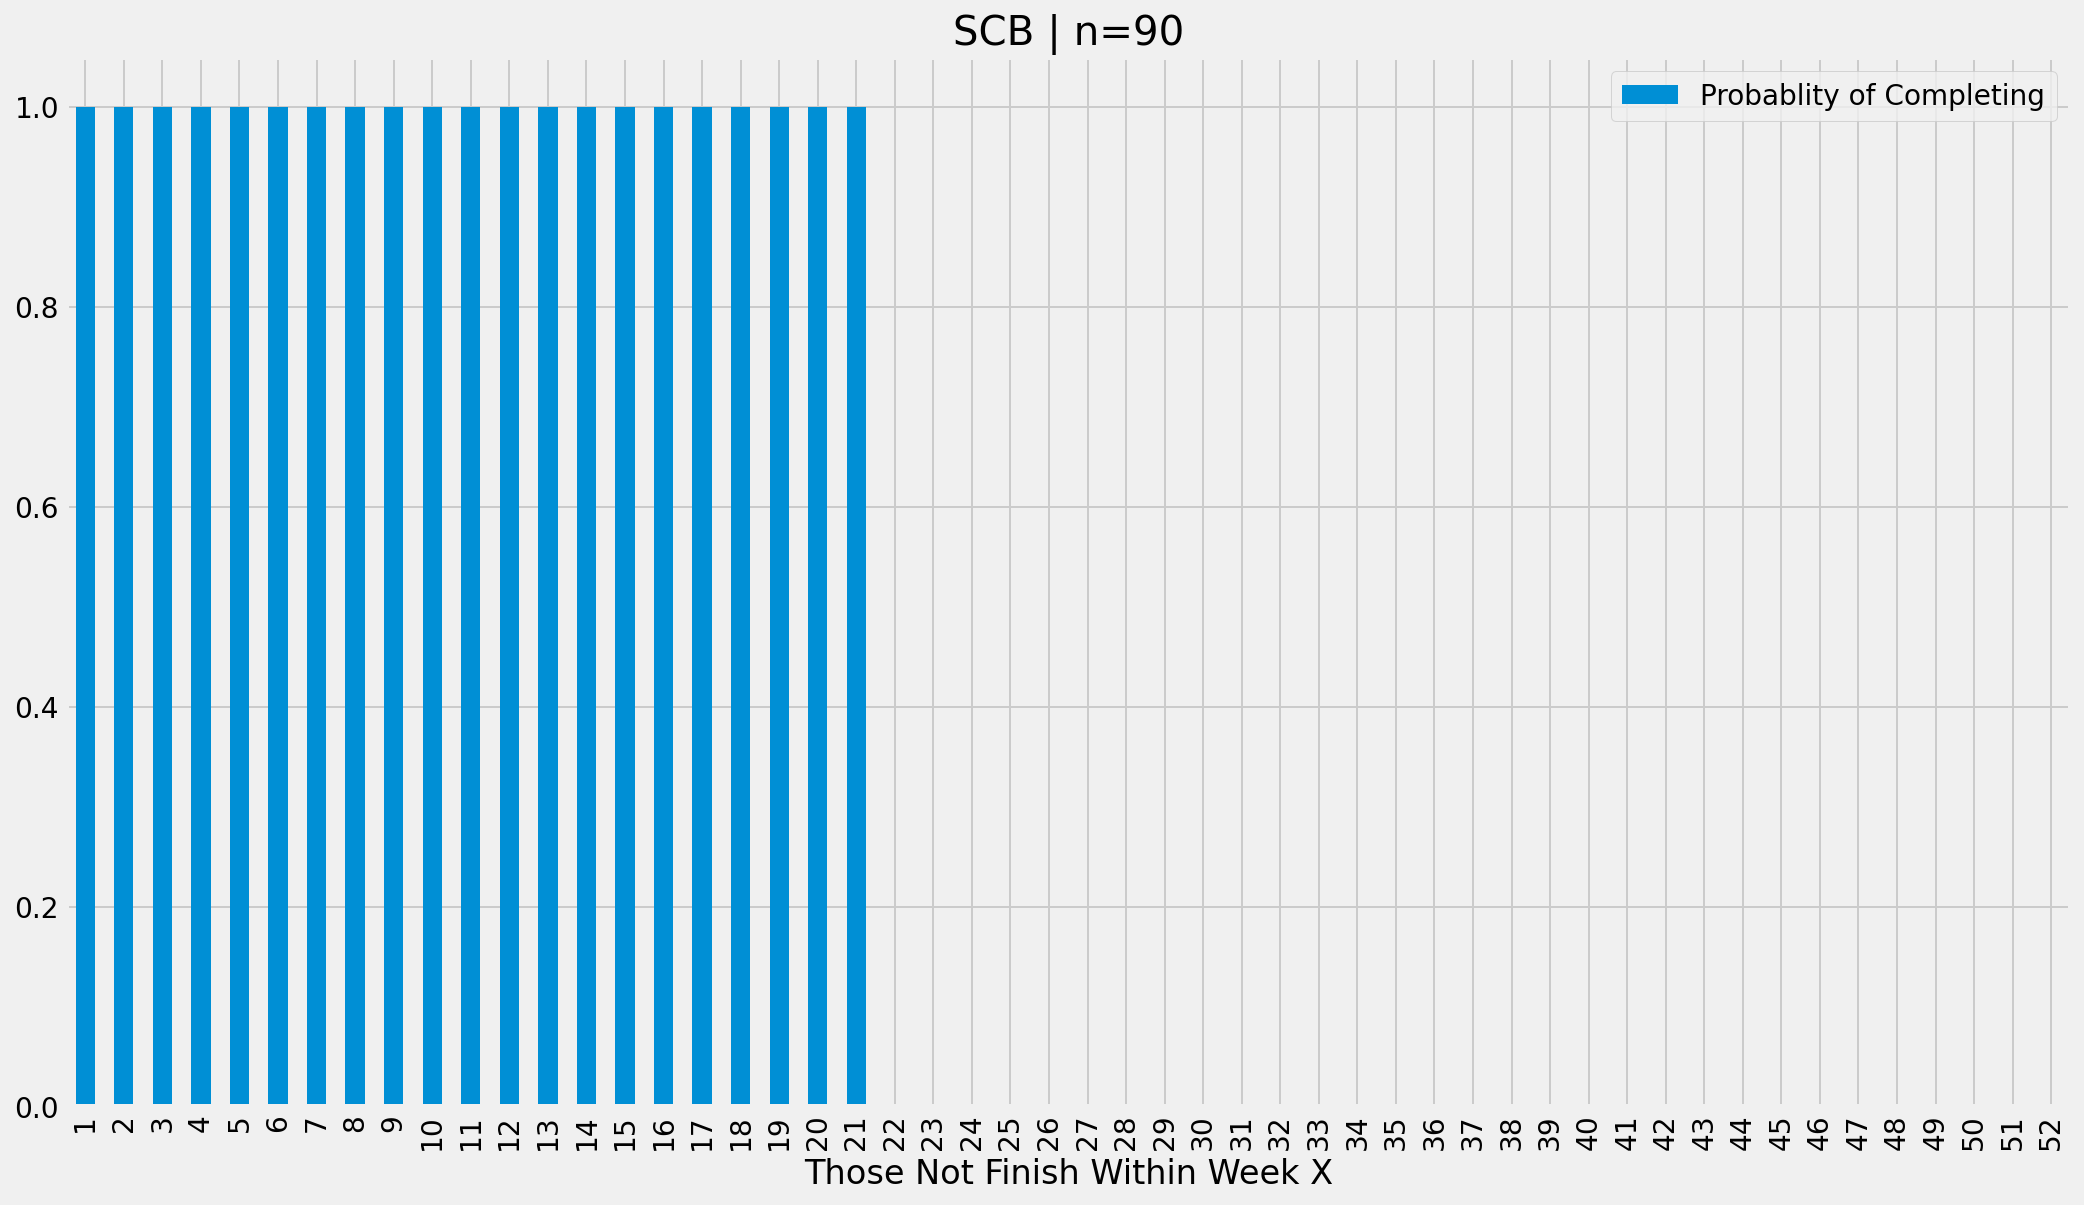

In [114]:
for agen in df.Agency.unique()[:10]:
    dfx = df[df.Agency == agen]
    data = [(x, generate_probablity_of_completion(dfx,x)) for x in range(1, 53, 1)]
    data = pd.DataFrame(list(data), columns=["Those Not Finish Within Week X", "Probablity of Completing"])
    data.plot(x='Those Not Finish Within Week X', y='Probablity of Completing', kind='bar')
    plt.title(agen + " | n=" + str(len(dfx)))

In [ ]:
plt.close()

In [106]:
data = pd.DataFrame(list(data), columns=["Those Not Finish Within Week X", "Probablity of Completing"])

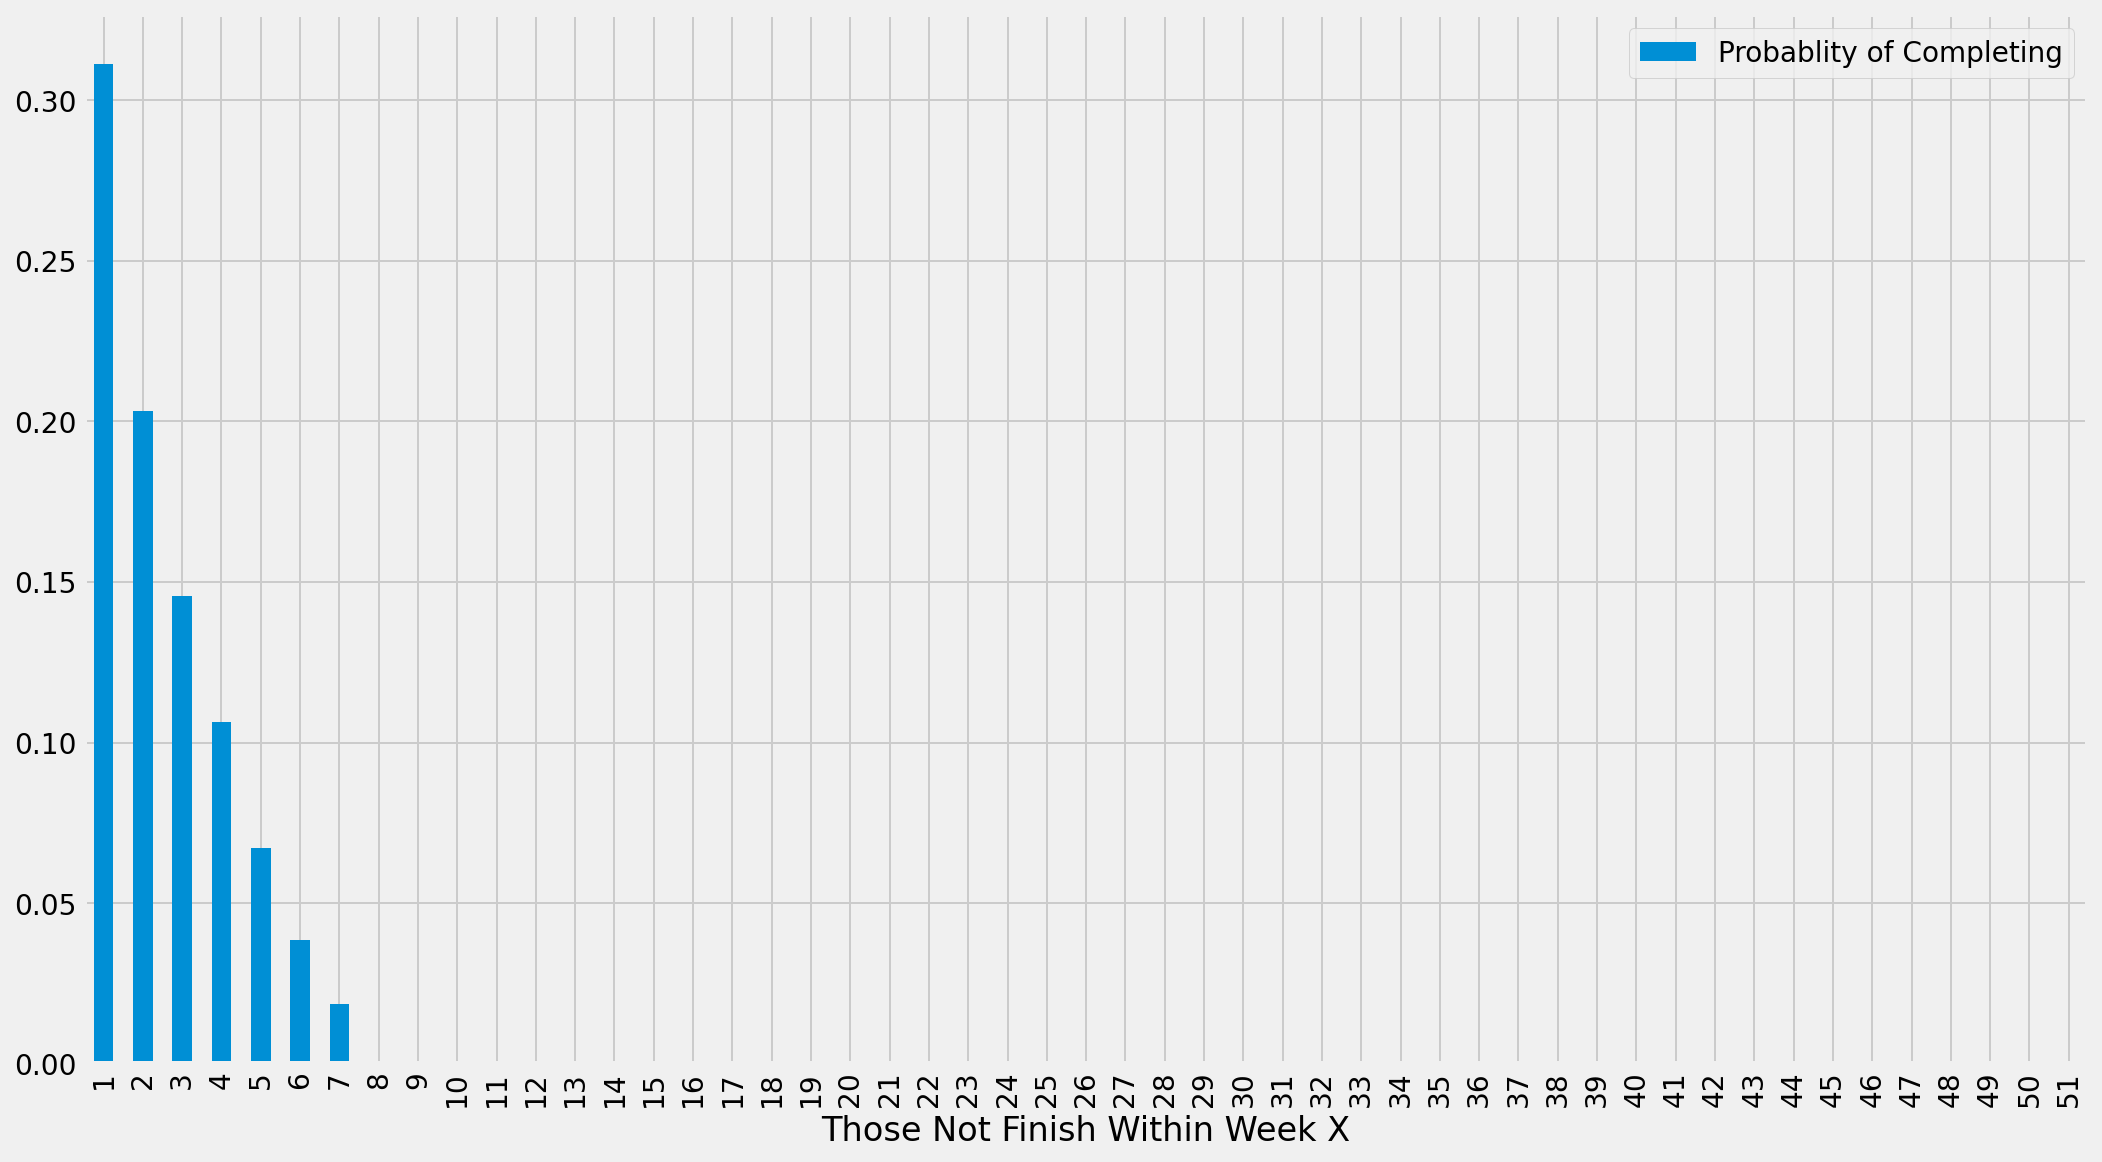

In [107]:
data.plot(x='Those Not Finish Within Week X', y='Probablity of Completing', kind='bar')

In [71]:
len(df) * completion_rate_btw

1491.6408893238677

In [45]:
len(df) * 0.06516561333874477 / len(df) * kmf.predict(week_in_minutes)

0.013642520576013248

In [44]:
kmf.predict(week_in_minutes)

0.2093515257056895

In [ ]:
 - len(df) * 0.06516561333874477

In [31]:
kmf.predict(week_in_minutes * 52)

0.14418591236694472

In [59]:
# Probablity of Completion after 1 Week
n_at_risk = df[df.duration >= week_in_minutes]
len(n_at_risk[n_at_risk.Completed == 'Completed']) / len(n_at_risk)

0.3576281655342804

In [82]:
# Probablity of Completion after 1 Week
n_at_risk = df[df.duration >= week_in_minutes * 3]
len(n_at_risk[n_at_risk.event == 1]) / len(n_at_risk)

0.22291407222914073

In [41]:
df_kmf

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,621,621,0,22890,22890
1.0,1121,1121,0,0,22269
2.0,1536,1536,0,0,21148
3.0,1207,1207,0,0,19612
4.0,860,860,0,0,18405
...,...,...,...,...,...
717409.0,1,0,1,0,5
722681.0,1,0,1,0,4
755722.0,1,0,1,0,3


In [73]:
df_cond_time_to_completion = kmf.conditional_time_to_event_.reset_index()

In [67]:
dtale.show(df_cond_time_to_completion)

In [74]:
df_cond_time_to_completion.columns

Index(['timeline', 'e-Primer Completion Data - Conditional median duration remaining to event'], dtype='object')

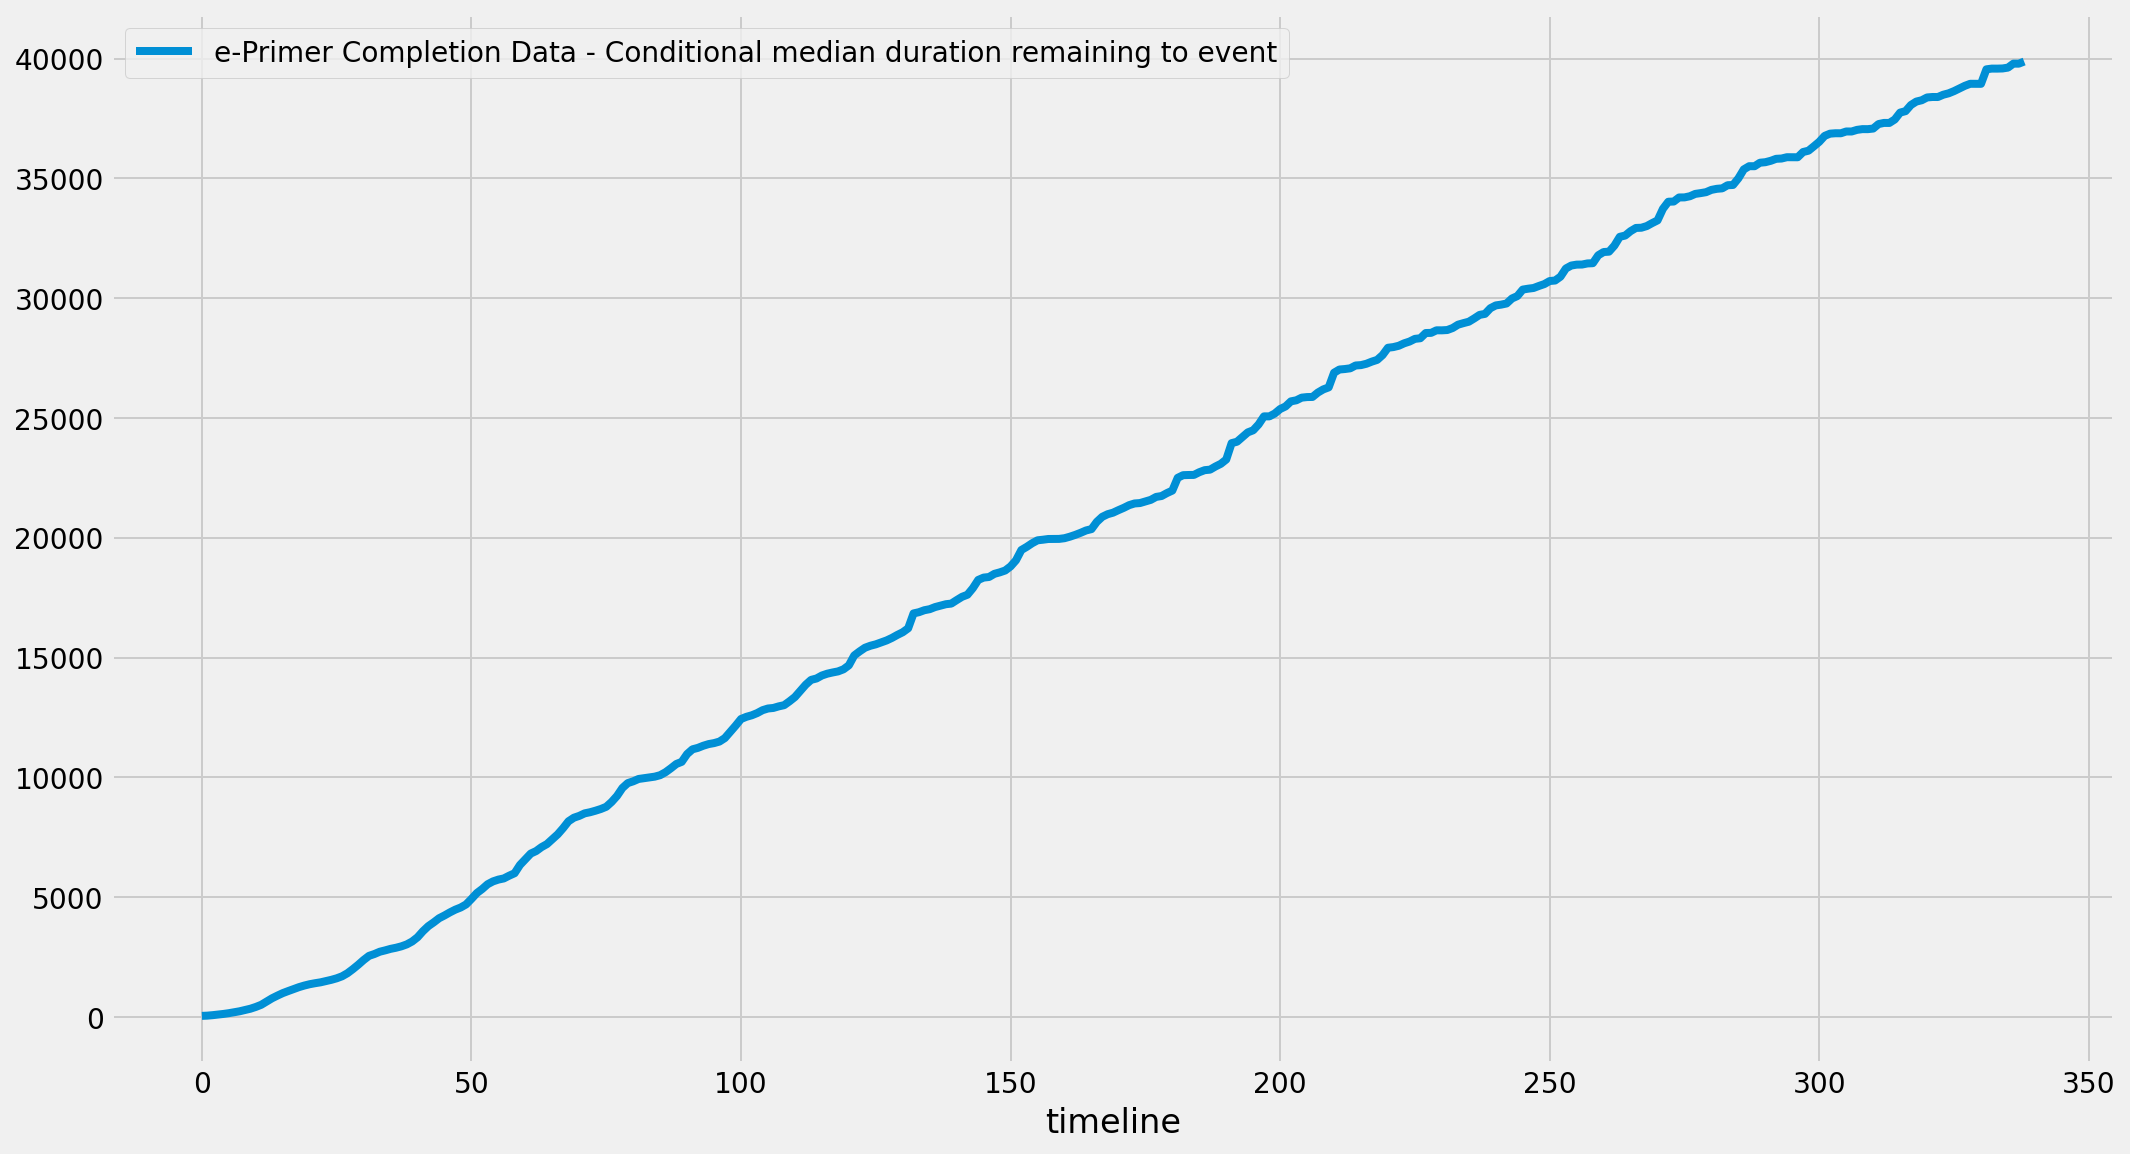

In [75]:
df_cond_time_to_completion.plot(x='timeline', y=df_cond_time_to_completion.columns[1])

In [47]:
kmf.survival_function_.iloc[wee]

e-Primer Completion Data    0.198777
Name: 14000.0, dtype: float64

In [48]:
kmf.survival_function_.iloc[10000]

e-Primer Completion Data    0.213237
Name: 10000.0, dtype: float64

In [50]:
 (0.213237 - 0.198777)*100

1.4460000000000002

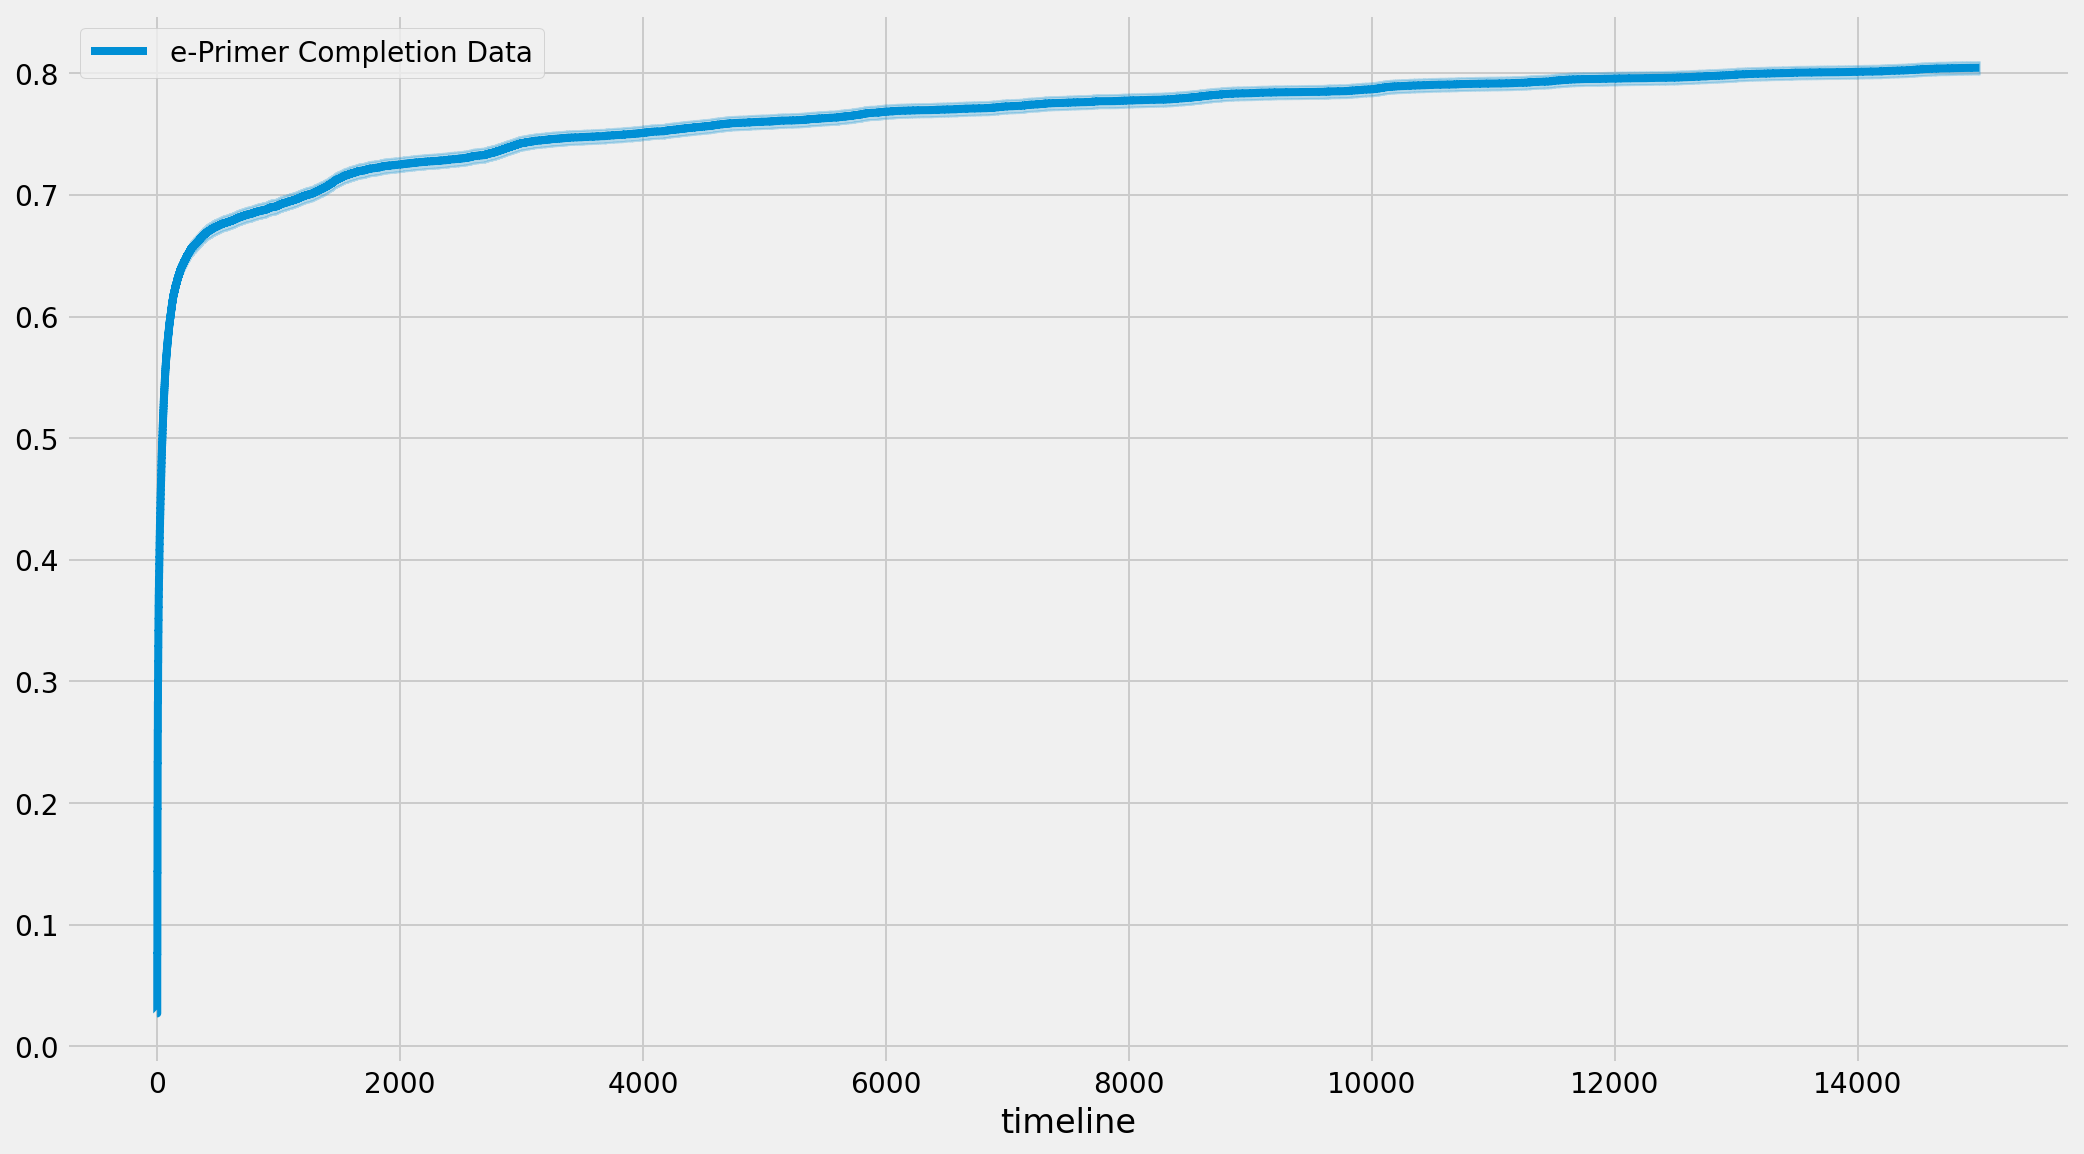

In [28]:
kmf.plot_cumulative_density()

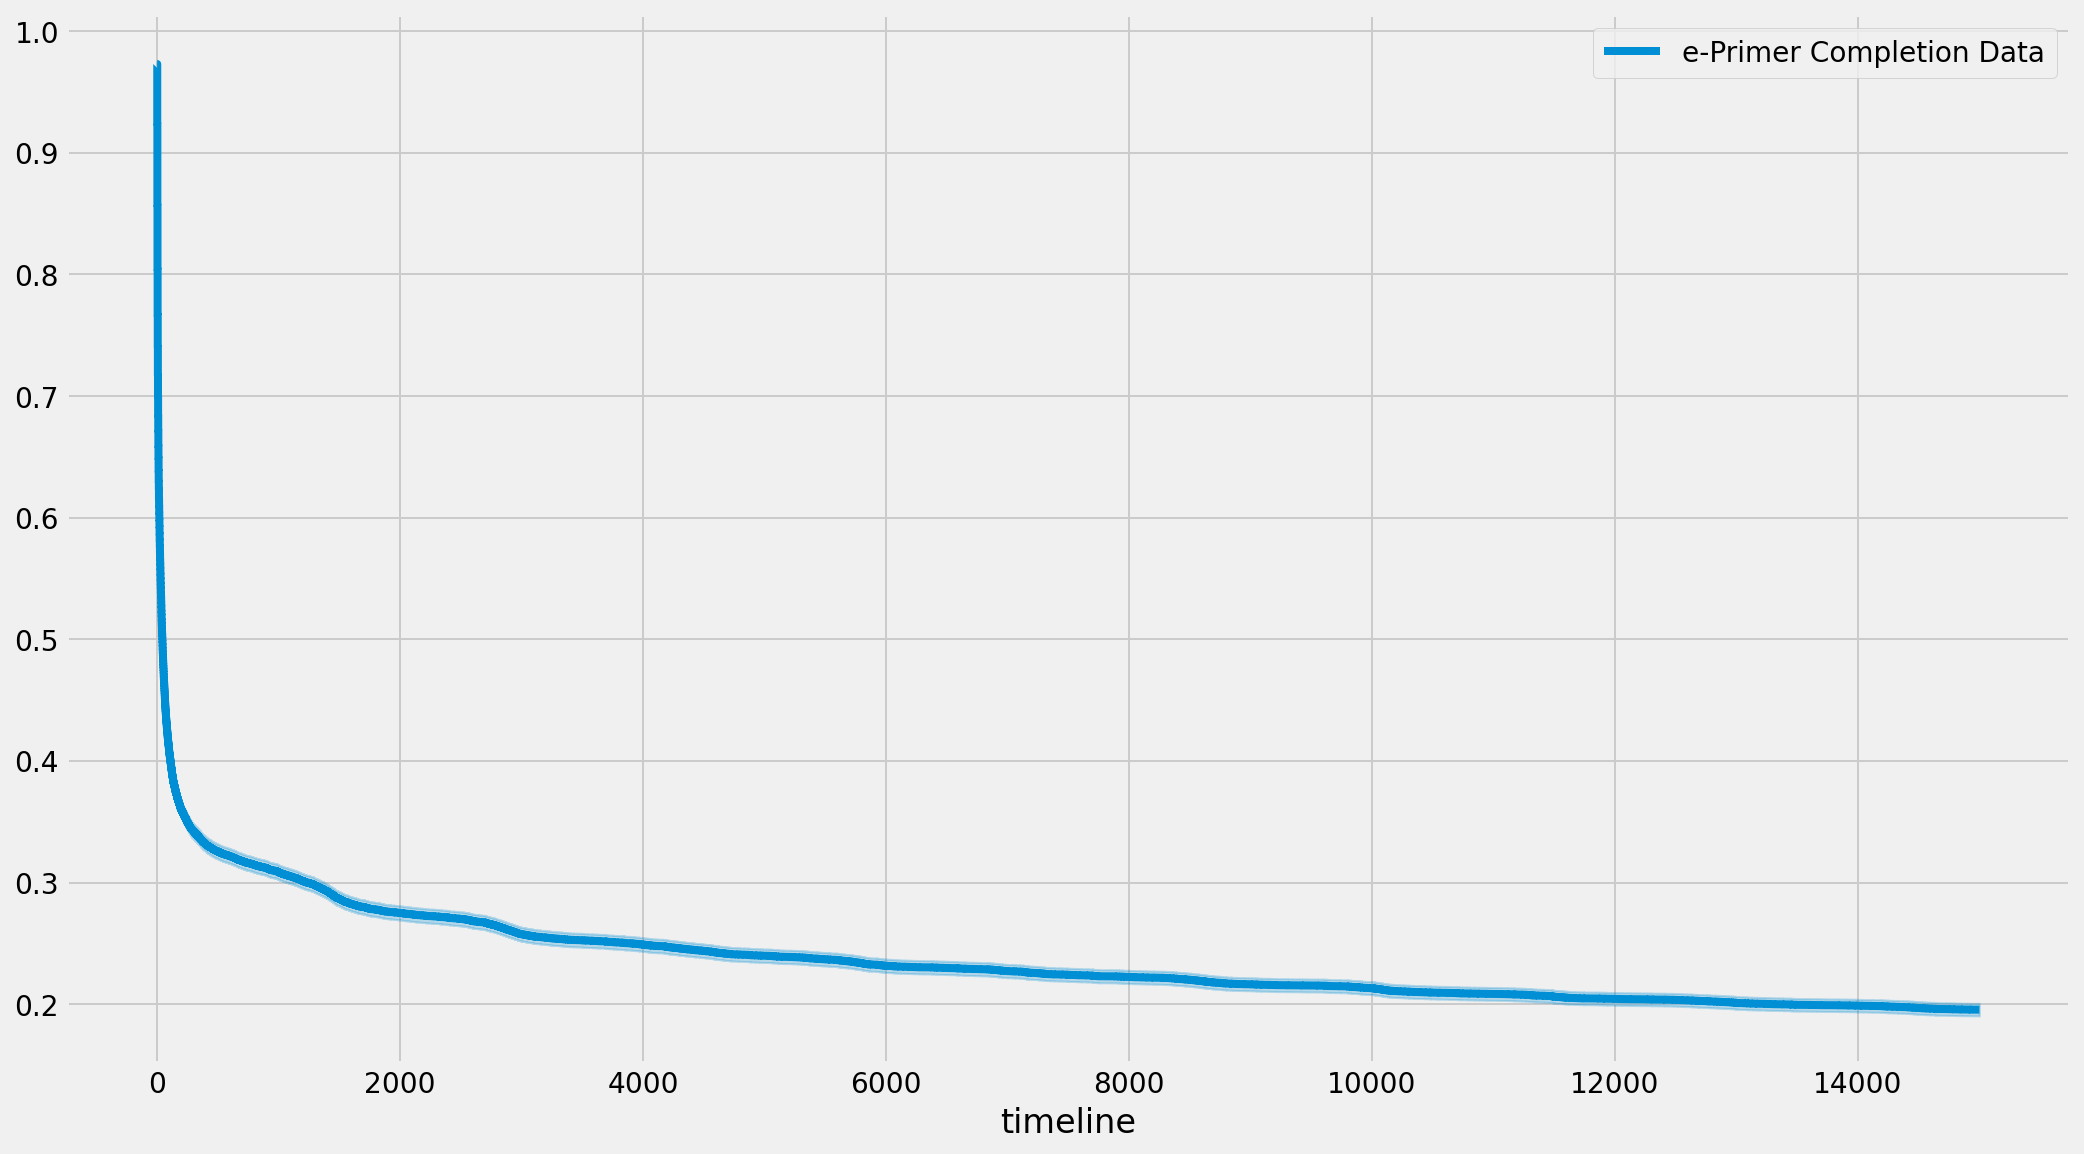

In [30]:
kmf.plot_survival_function()

In [22]:
kmf.cumulative_density_at_times(10000)

10000    0.786763
Name: e-Primer Completion Data, dtype: float64

In [26]:
kmf.cumulative_hazard_at_times(3)

NotImplementedError: 

## Nelson Aalen Estimator

In [12]:
from lifelines import NelsonAalenFitter

<lifelines.NelsonAalenFitter:"NAF", fitted with 22890 total observations, 3120 right-censored observations>

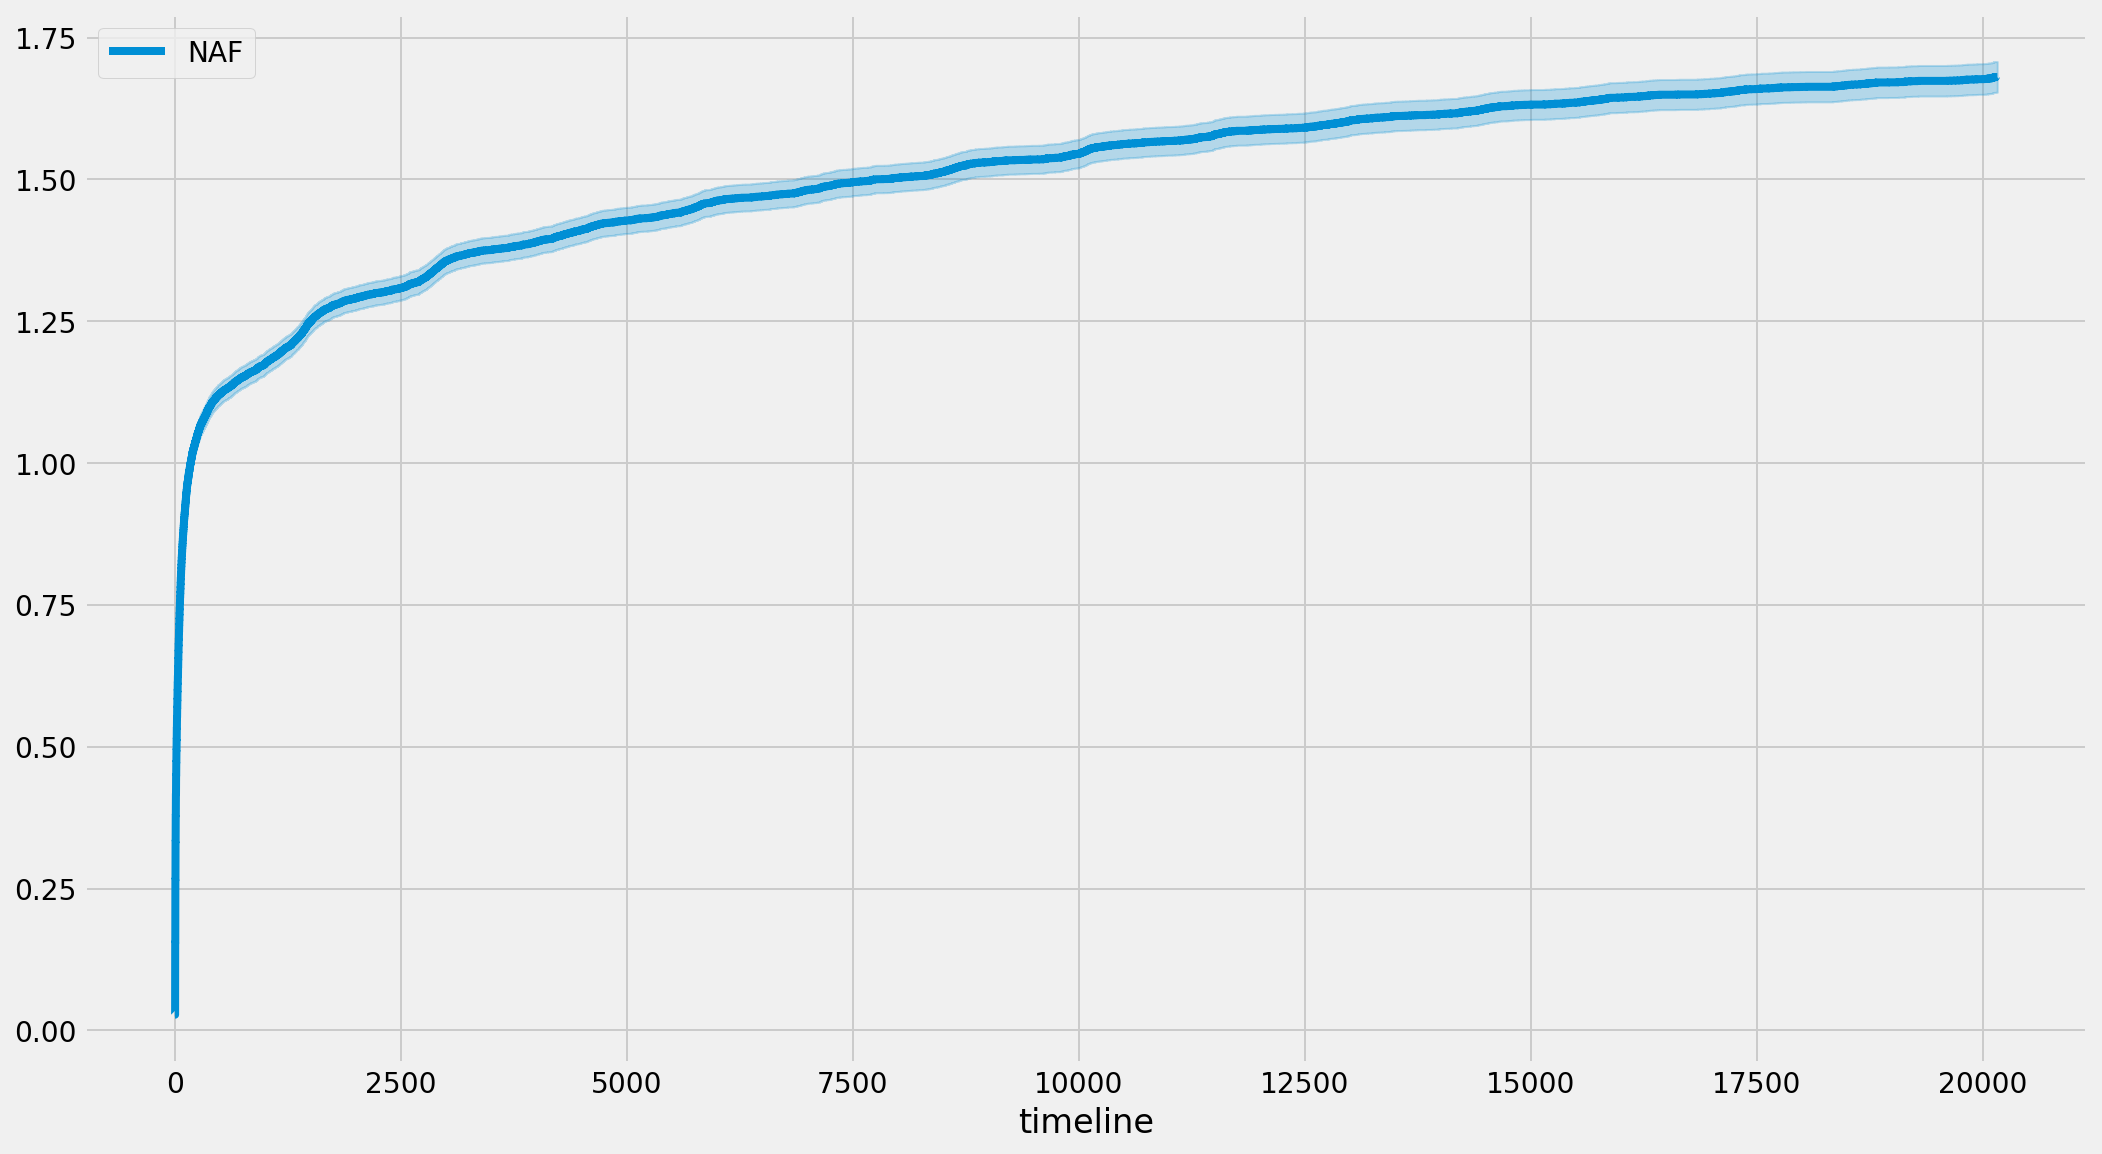

In [18]:
naf = NelsonAalenFitter(label='NAF')
naf.fit(df['duration'], df['event'], range(0, 20160,1))
naf.plot()

In [118]:
def fit_kmf(dfg):
    naf = NelsonAalenFitter(label=dfg.name)
    naf.fit(dfg['duration'], dfg['event'], range(0, 20160,1))
    naf.plot(ci_show=True)

# Manual

In [55]:
week_in_minutes = 7*24*60

In [99]:
df_sub = df[(df.total_minutes >= week_in_minutes*2) | (df.Completed != 'Completed')]

In [100]:
df_sub.ds.len

4261

In [101]:
len(df_sub[df_sub.Completed != 'Completed']) 

3120

In [102]:
len(df_sub[df_sub.Completed == 'Completed']) / df_sub.ds.len

0.26777751701478525

In [38]:
df_sub = df[(df.total_minutes >= week_in_minutes)]

In [40]:
df.to_csv('data/outputs/processed_data_surv.csv', index=False, encoding='utf-8')

In [41]:
df['T']

0         65435.0
1         65472.0
2             2.0
3         65501.0
4         65501.0
           ...   
22885    762963.0
22886    764335.0
22887    140889.0
22888    153024.0
22889     44999.0
Name: T, Length: 22890, dtype: float64

In [44]:
len(df[df.total_minutes <= 3]) / len(df)

0.19593709043250326

In [47]:
df['T'].value_counts()

2.0         1536
3.0         1207
1.0         1121
4.0          860
0.0          621
            ... 
152731.0       1
72270.0        1
259230.0       1
72272.0        1
2069.0         1
Name: T, Length: 7232, dtype: int64

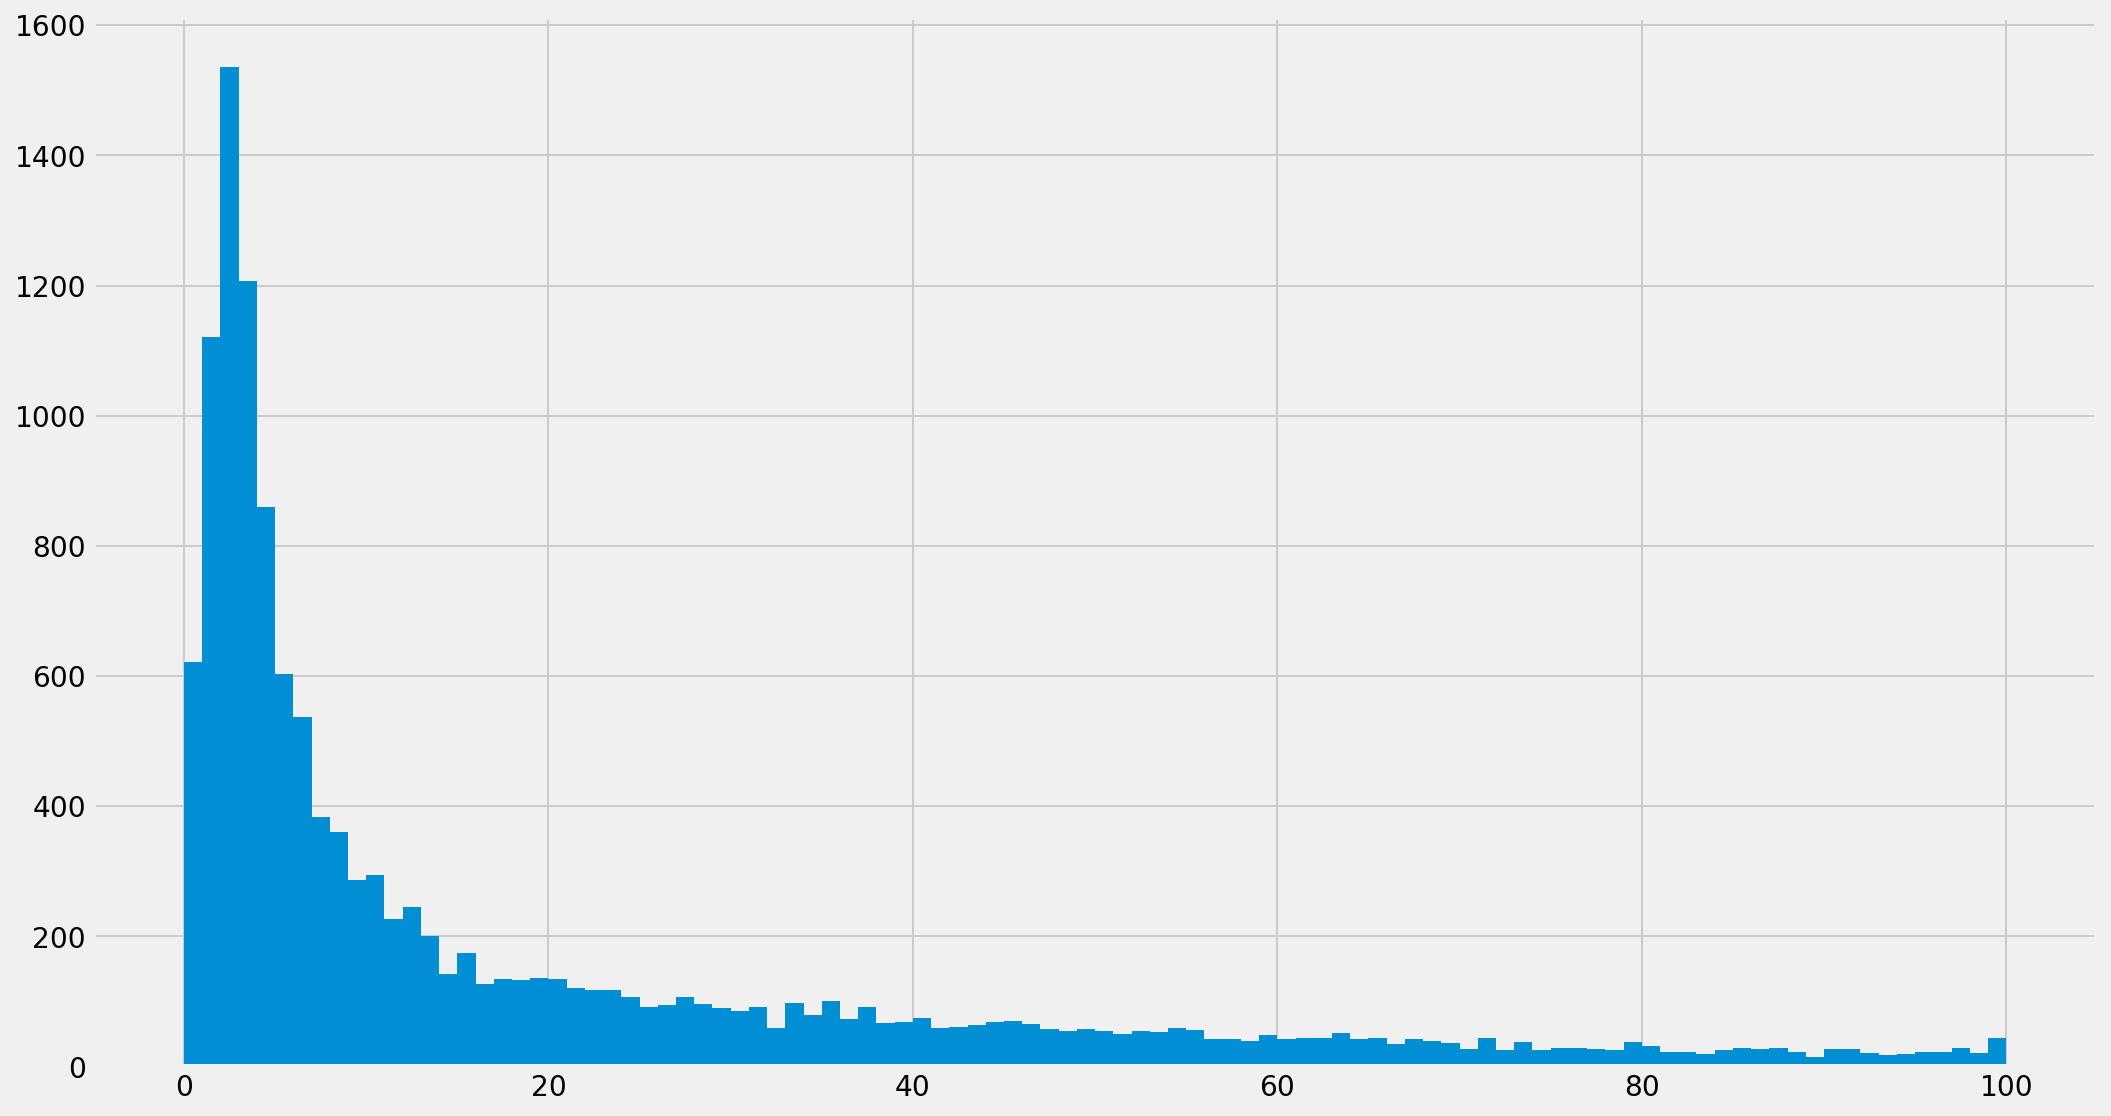

In [52]:
df[df.duration <= 100].duration.hist(bins=100)